##### 1.0 Import the required libraries

In [1]:
pip install scikit-posthocs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import levene,kruskal
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy.stats import chi2_contingency
import itertools
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

interest_rate_df_eda = pd.read_csv('/content/drive/MyDrive/Ijaz - Updated Files/Dissertation - Masters Project/Loan Interest Rate Prediction (ML Model Development)/Interest Rate Model Development - ML/interest_rate_df_engineered.csv')
print(interest_rate_df_eda.shape) # (757494, 48)
display(interest_rate_df_eda.head())

(757494, 48)


loan_amnt  funded_amnt  funded_amnt_inv       term  int_rate  installment  \
0    27050.0      27050.0          27050.0  36 months     10.99       885.46   
1     9750.0       9750.0           9750.0  36 months     13.98       333.14   
2    12000.0      12000.0          12000.0  36 months      6.62       368.45   
3    12000.0      12000.0          12000.0  36 months     13.53       407.40   
4    15000.0      15000.0          15000.0  36 months      8.90       476.30   

  grade sub_grade                            emp_title  emp_length  ...  \
0     B        B2  Team Leadern Customer Ops & Systems          10  ...   
1     C        C1                    Medical Assistant           1  ...   
2     A        A2         MANAGER INFORMATION DELIVERY          10  ...   
3     B        B5                      On road manager          10  ...   
4     A        A5        aircraft maintenance engineer           2  ...   

  collection_recovery_fee  last_pymnt_d last_pymnt_amnt next_pymnt_d  \
0                     0.0      Jan-2016          885.46     Feb-2016   
1                     0.0      Jan-2016          333.14     Feb-2016   
2                     0.0      Jan-2016          368.45     Feb-2016   
3                     0.0      Sep-2015          119.17      Unknown   
4                     0.0      Jan-2016          476.30     Feb-2016   

  last_credit_pull_d collections_12_mths_ex_med acc_now_delinq tot_coll_amt  \
0           Dec-2015                          0              0          0.0   
1           Jan-2016                          0              0          0.0   
2           Jan-2016                          0              0          0.0   
3           Jan-2016                          0              0      15386.0   
4           Jan-2016                          0              0       1514.0   

  tot_cur_bal total_rev_hi_lim  
0    114834.0          59900.0  
1     14123.0          15100.0  
2    267646.0          61100.0  
3     13605.0           8100.0  
4    272492.0          15400.0  

[5 rows x 48 columns]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### 1.1 Numerical Variable Analysis

In [4]:
# Identify the numerical and categroical variables

numerical_cols = interest_rate_df_eda.select_dtypes(include = ['int64','float64']).columns
categorical_cols = interest_rate_df_eda.select_dtypes(include = ['object','category']).columns
print(len(numerical_cols)) # 30 numerical variables
print(len(categorical_cols)) # 18 categorical variables
print(numerical_cols)
print(categorical_cols)

30
18
Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')
Index(['term', 'grade', 'sub_grade', 'emp_title', 'home_ownership',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_pymnt_d', 'next_pymnt_d',
       'last_credit_pull_d'],
      dtype='object')


##### 1.1.1 Identify the continuous and discrete variables

In [5]:
continuous_vars = interest_rate_df_eda[numerical_cols].select_dtypes(include = ['float64']).columns
discrete_vars = interest_rate_df_eda[numerical_cols].select_dtypes(include = ['int64']).columns
print(len(continuous_vars)) # 22 continuous variables
print(len(discrete_vars)) # 8 discrete variables

22
8


##### Reference List - Continuous Variables

In [6]:
# Variable Description (Continuous Variables)
# Interest Rates - The interest rate charged for the loan.
# Loan Amount - The amount that the borrower applied for.
# Funded Amount - The amount that is funded or approved by the Lending Club (LC).
# Funded Amount (Investor) - The amount that the investor funded for the loan.
# Installment - The monthly repayment for the borrower on taking out the loan.
# Annual Income - The reported annual income of the borrower.
# DTI - The debt to income ratio of the borrower, excluding mortgages and the current loan.
# Revolving Balance - The amount of credit available in revolving accounts (for eg. credit cards)
# Revolving Utility - The percentage of available credit that the borrower has used.
# Outstanding Principal - The amount of principal that is remaining on the loan.
# Outstanding Principal (Investor) - The amount of principal that has to be paid to the investor for funding the loan.
# Total Payment - The total amount paid by the borrower.
# Total Payment (Investor) - The total amount paid to the investor.
# Total Principal (Recieved) - The amoount of principal paid by the borrower.
# Total Interest (Recieved) - The total interest recieved from the borrower.
# Total Late Fees - The total late fees collected from the borrower for payment defaults on a loan.
# Recoveries (Borrower) - The total amount recovered from the borrower after defaulting on a loan.
# Collection Recovery Fees - The amount charged by the collections agency for recovering the debt from the borrower.
# Last Payment Amount - Recent payment made by the borrower.
# Total Collections Amount - The amount of debt that has been sent to the collections agency.
# Total Current Balance - The current balance on borrowers credit accounts.
# Total Revolving Accounts (Limit) - The highest available credit limit across all credit accounts.

##### 1.1.2 Descriptive Statistics - Continuous Variables

In [7]:
display(interest_rate_df_eda[continuous_vars].describe(include = 'all'))

loan_amnt    funded_amnt  funded_amnt_inv       int_rate  \
count  757494.000000  757494.000000    757494.000000  757494.000000   
mean    14995.863829   14995.856271     14989.562783      13.313781   
std      8348.212823    8348.213080      8344.887716       4.405783   
min      1000.000000    1000.000000       925.000000       5.320000   
25%      8500.000000    8500.000000      8500.000000       9.990000   
50%     13600.000000   13600.000000     13600.000000      12.990000   
75%     20000.000000   20000.000000     20000.000000      16.290000   
max     35000.000000   35000.000000     35000.000000      28.990000   

         installment     annual_inc            dti      revol_bal  \
count  757494.000000  757494.000000  757494.000000  757494.000000   
mean      442.383760   72619.525048      18.518007   16653.804882   
std       240.397747   35547.017089       8.256356   18754.408488   
min        23.260000    4000.000000       0.000000       0.000000   
25%       268.360000   47000.000000      12.320000    6633.000000   
50%       389.300000   65000.000000      18.040000   12052.000000   
75%       577.440000   90000.000000      24.380000   20929.000000   
max      1445.460000  221000.000000      39.990000  814300.000000   

          revol_util      out_prncp  ...  total_pymnt_inv  total_rec_prncp  \
count  757494.000000  757494.000000  ...    757494.000000    757494.000000   
mean       55.446303    9098.549002  ...      7112.268233      5377.306872   
std        23.417762    8448.137464  ...      7517.332429      6388.690378   
min         0.000000       0.000000  ...         0.000000         0.000000   
25%        38.300000    1081.390000  ...      1796.980000      1120.210000   
50%        56.200000    7597.470000  ...      4522.190000      2943.880000   
75%        73.500000   14316.755000  ...      9926.075000      7165.550000   
max       892.300000   35000.000000  ...     56047.850000     35000.000000   

       total_rec_int  total_rec_late_fee     recoveries  \
count  757494.000000       757494.000000  757494.000000   
mean     1697.604429            0.319263      40.231105   
std      2001.252341            3.643669     374.384245   
min         0.000000            0.000000       0.000000   
25%       427.460000            0.000000       0.000000   
50%      1047.395000            0.000000       0.000000   
75%      2182.500000            0.000000       0.000000   
max     21840.000000          358.680000   33520.270000   

       collection_recovery_fee  last_pymnt_amnt  tot_coll_amt   tot_cur_bal  \
count            757494.000000    757494.000000  7.574940e+05  7.574940e+05   
mean                  4.291250      2122.563854  2.218156e+02  1.363523e+05   
std                  52.856373      4794.821158  1.069016e+04  1.400039e+05   
min                   0.000000         0.000000  0.000000e+00  0.000000e+00   
25%                   0.000000       284.350000  0.000000e+00  3.062100e+04   
50%                   0.000000       459.670000  0.000000e+00  8.128700e+04   
75%                   0.000000       785.620000  0.000000e+00  2.071658e+05   
max                5694.093600     36475.590000  9.152545e+06  3.610743e+06   

       total_rev_hi_lim  
count      7.574940e+05  
mean       3.130817e+04  
std        2.900280e+04  
min        0.000000e+00  
25%        1.400000e+04  
50%        2.360000e+04  
75%        3.940000e+04  
max        1.119200e+06  

[8 rows x 22 columns]

##### 1.1.3 Distribution Function (Continuous Variables)

In [8]:
def continuous_variable_analysis(data,variable_name):
    # Determine key statistics
    mean_value = data[variable_name].mean()  # Mean of the variable
    median_value = data[variable_name].median()  # Median of the variable
    std_value = data[variable_name].std()  # Standard Deviation of the variable
    min_value = data[variable_name].min()  # Minimum Value of the variable
    max_value = data[variable_name].max()  # Maximum Value of the variable
    cv_value = std_value / mean_value  # Coefficient of Variation

    # Print the statistics
    print(f'Mean {variable_name}: {mean_value}')
    print(f'Median {variable_name}: {median_value}')
    print(f'Standard Deviation {variable_name}: {std_value}')
    print(f'Minimum {variable_name}: {min_value}')
    print(f'Maximum {variable_name}: {max_value}')
    print(f'Coefficient of Variation {variable_name}: {cv_value}')

    # Analyse the distribution (Histogram with KDE)
    sns.set(style = "whitegrid")
    plt.figure(figsize = (10, 6))
    ax = sns.histplot(data = data,x = variable_name,kde = True,color = "coral",bins = 20)
    plt.title(f'Distribution ~ {variable_name.capitalize()}',fontsize = 16,loc = 'left',pad = 30)
    plt.text(0, 1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
    plt.xlabel(f'{variable_name.capitalize()}',fontsize = 14)
    plt.ylabel('Frequency',fontsize = 14)

    # Display the plot
    plt.show()

    # Test for normality using the Shapiro-Wilk Test
    shapiro_test = stats.shapiro(data[variable_name])
    print(f'Shapiro-Wilk Test Statistic: {shapiro_test.statistic:.5f}')
    print(f'p-value: {shapiro_test.pvalue:.5f}')

    # Returns the output in a dictionary form
    return {
        'mean': mean_value,
        'median': median_value,
        'std_dev': std_value,
        'min': min_value,
        'max': max_value,
        'coefficient_of_variation': cv_value,
        'shapiro_wilk_stat': shapiro_test.statistic,
        'shapiro_wilk_p_value': shapiro_test.pvalue
    }

##### 1.1.4 Analyse the distribution of continuous variables

##### A : Target Variable : Interest Rate

Mean Interest Rate: 13.313781350083309
Median Interest Rate: 12.99
Minimum Interest Rate: 5.32
Maximum Interest Rate: 28.99
Coefficient of Variation Interest Rate: 0.330918951658441


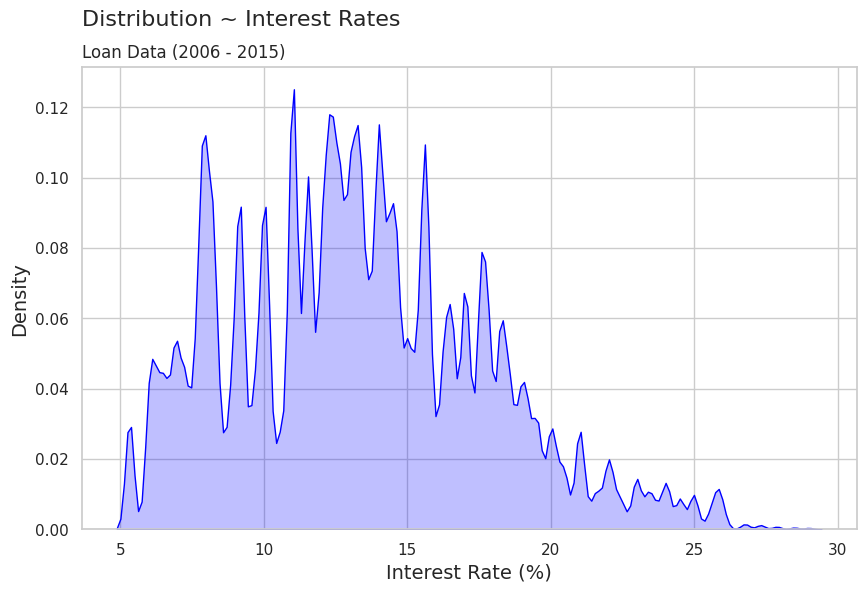

Shapiro-Wilk Test Statistic: 0.9798028661931972
p-value: 2.53855732329766e-103


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


In [9]:
# Interest Rates
mean_interest_rate = interest_rate_df_eda['int_rate'].mean()
median_interest_rate = interest_rate_df_eda['int_rate'].median()
min_interest_rate = interest_rate_df_eda['int_rate'].min()
max_interest_rate = interest_rate_df_eda['int_rate'].max()
std_interest_rate = interest_rate_df_eda['int_rate'].std()
cv_interest_rate = std_interest_rate / mean_interest_rate
print(f'Mean Interest Rate: {mean_interest_rate}') # 13.314%
print(f'Median Interest Rate: {median_interest_rate}') # 12.99%
print(f'Minimum Interest Rate: {min_interest_rate}') # 5.32%
print(f'Maximum Interest Rate: {max_interest_rate}') # 28.99%
print(f'Coefficient of Variation Interest Rate: {cv_interest_rate}') # 33.092%

# Inspect the distribution of interest rates (Histogram)
sns.set(style = "whitegrid")
plt.figure(figsize = (10,6))
ax = sns.kdeplot(data=interest_rate_df_eda,x = "int_rate",fill = True,color = "blue",bw_adjust = 0.5)
plt.title('Distribution ~ Interest Rates',fontsize = 16,loc = 'left',pad = 30)
plt.text(0, 1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
plt.xlabel('Interest Rate (%)',fontsize = 14)
plt.ylabel('Density',fontsize = 14)
plt.show()

# Normality Check
interest_rate_normality_test = stats.shapiro(interest_rate_df_eda['int_rate'])
print(f'Shapiro-Wilk Test Statistic: {interest_rate_normality_test[0]}')
print(f'p-value: {interest_rate_normality_test[1]}')

# Key Insights:
# The mean is slightly greater than the median, indicating a slight positively skewed distribution.
# The interest rates vary by approximately 33.092% around the mean and indicate signficant variability.
# From the histogram, it is clear that there are some interest rates that are signficantly higher and approaching
# close to 30%, which skews the distribution to the right.
# The extremely low p-value suggests that the data is not normally distributed.

##### B : Loan Amount (Borrower)

Mean loan_amnt: 14995.863828624386
Median loan_amnt: 13600.0
Standard Deviation loan_amnt: 8348.212822819918
Minimum loan_amnt: 1000.0
Maximum loan_amnt: 35000.0
Coefficient of Variation loan_amnt: 0.5567010289120319


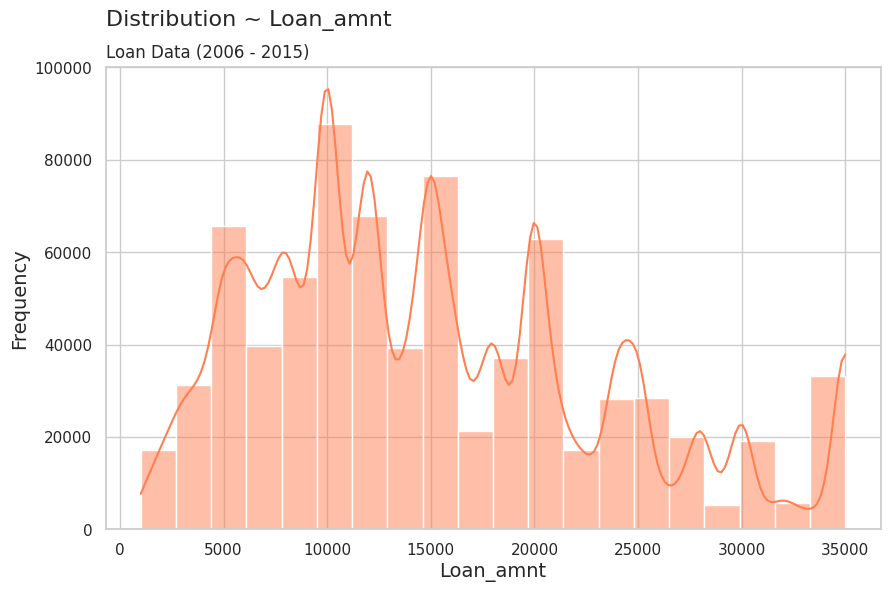

Shapiro-Wilk Test Statistic: 0.94951
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 14995.863828624386,
 'median': 13600.0,
 'std_dev': 8348.212822819918,
 'min': 1000.0,
 'max': 35000.0,
 'coefficient_of_variation': 0.5567010289120319,
 'shapiro_wilk_stat': 0.949514694348752,
 'shapiro_wilk_p_value': 3.322696097358199e-129}

In [10]:
# Loan Amount (Borrower)
continuous_variable_analysis(interest_rate_df_eda,'loan_amnt')
# The mean is greater than the median, indicating a positively skewed distribution.
# Some borrowers have applied for higher loan amounts, and this indicates the skewness in the distribution.
# The range of the loan amount is between 1000 and 35000.
# The coefficient of variation (55.670%) around the mean reflects signficant variability in loan amounts.
# The extremely low-pvalue suggest that the data is not normally distributed.

##### C : Funded Amount (Approved Amount)


Mean funded_amnt: 14995.856270808747
Median funded_amnt: 13600.0
Standard Deviation funded_amnt: 8348.21308004401
Minimum funded_amnt: 1000.0
Maximum funded_amnt: 35000.0
Coefficient of Variation funded_amnt: 0.5567013266388009


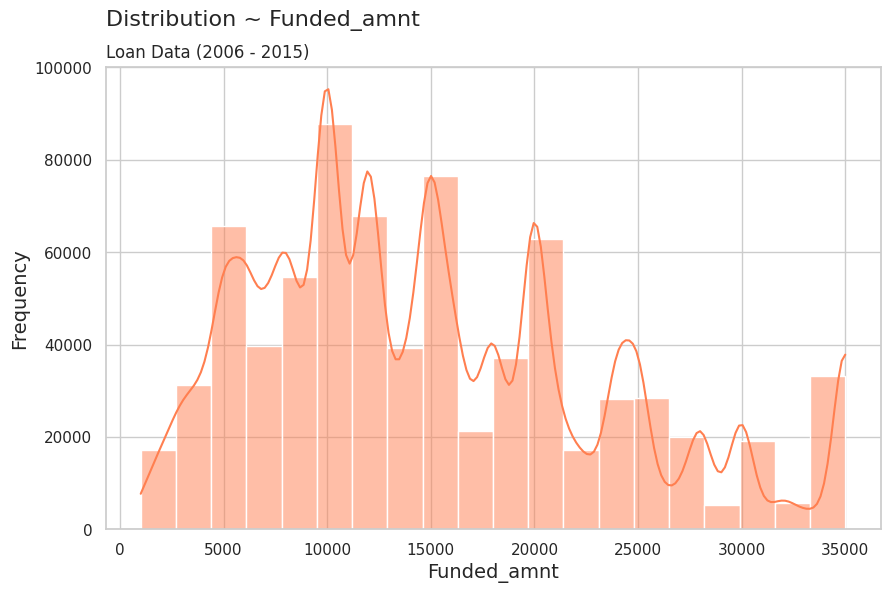

Shapiro-Wilk Test Statistic: 0.94951
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 14995.856270808747,
 'median': 13600.0,
 'std_dev': 8348.21308004401,
 'min': 1000.0,
 'max': 35000.0,
 'coefficient_of_variation': 0.5567013266388009,
 'shapiro_wilk_stat': 0.9495147679661221,
 'shapiro_wilk_p_value': 3.323029188665663e-129}

In [11]:
# Funded Amount
continuous_variable_analysis(interest_rate_df_eda,'funded_amnt')
# This is the amount that is approved by the Lending Club (LC).

##### D : Funded Amount (Investor Contribution)

Mean funded_amnt_inv: 14989.562783242523
Median funded_amnt_inv: 13600.0
Standard Deviation funded_amnt_inv: 8344.887715744544
Minimum funded_amnt_inv: 925.0
Maximum funded_amnt_inv: 35000.0
Coefficient of Variation funded_amnt_inv: 0.5567132168173479


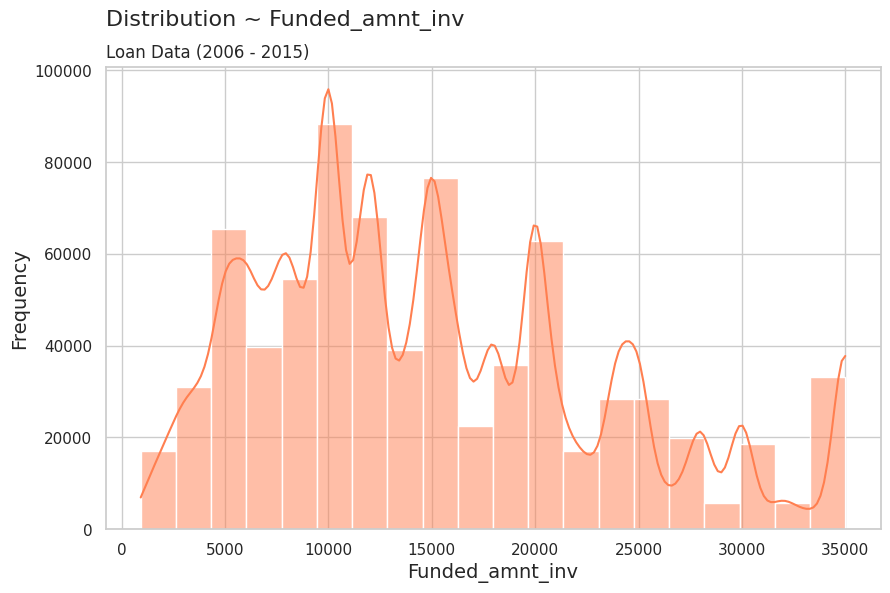

Shapiro-Wilk Test Statistic: 0.94959
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 14989.562783242523,
 'median': 13600.0,
 'std_dev': 8344.887715744544,
 'min': 925.0,
 'max': 35000.0,
 'coefficient_of_variation': 0.5567132168173479,
 'shapiro_wilk_stat': 0.9495940378314105,
 'shapiro_wilk_p_value': 3.7020651331709494e-129}

In [12]:
# funded_amnt_inv
continuous_variable_analysis(interest_rate_df_eda,'funded_amnt_inv')
# This is the amount that is contributed by the investor.

##### E : Installment (Borrower Monthly Repayment)

Mean installment: 442.3837599637754
Median installment: 389.3
Standard Deviation installment: 240.3977472109714
Minimum installment: 23.26
Maximum installment: 1445.46
Coefficient of Variation installment: 0.5434144943084176


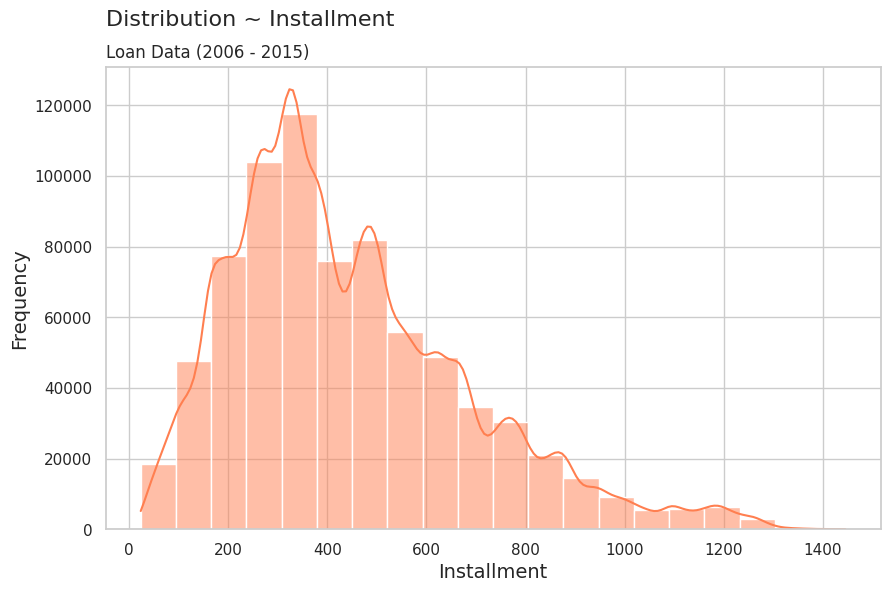

Shapiro-Wilk Test Statistic: 0.94391
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 442.3837599637754,
 'median': 389.3,
 'std_dev': 240.3977472109714,
 'min': 23.26,
 'max': 1445.46,
 'coefficient_of_variation': 0.5434144943084176,
 'shapiro_wilk_stat': 0.9439139321467084,
 'shapiro_wilk_p_value': 2.297235887377039e-132}

In [13]:
# installment
continuous_variable_analysis(interest_rate_df_eda,'installment')

##### F : Annual Income (Borrower)

Mean annual_inc: 72619.5250482908
Median annual_inc: 65000.0
Standard Deviation annual_inc: 35547.017089382054
Minimum annual_inc: 4000.0
Maximum annual_inc: 221000.0
Coefficient of Variation annual_inc: 0.48949668929594164


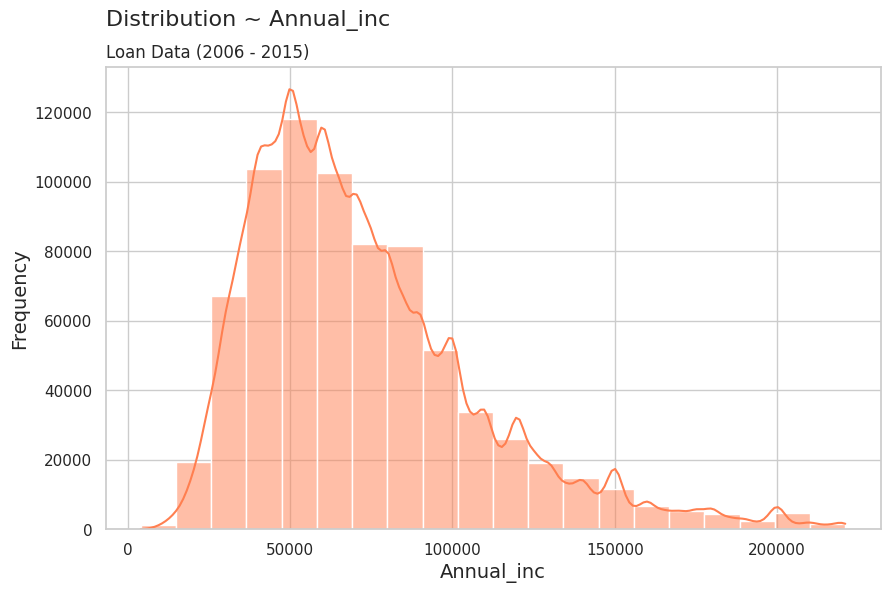

Shapiro-Wilk Test Statistic: 0.91572
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 72619.5250482908,
 'median': 65000.0,
 'std_dev': 35547.017089382054,
 'min': 4000.0,
 'max': 221000.0,
 'coefficient_of_variation': 0.48949668929594164,
 'shapiro_wilk_stat': 0.9157158250468199,
 'shapiro_wilk_p_value': 5.76373285194507e-145}

In [14]:
# annual_inc
continuous_variable_analysis(interest_rate_df_eda,'annual_inc')

##### G : Debt To Income Ratio (Borrower)

Mean dti: 18.51800742976183
Median dti: 18.04
Standard Deviation dti: 8.256355811161036
Minimum dti: 0.0
Maximum dti: 39.99
Coefficient of Variation dti: 0.44585551887680747


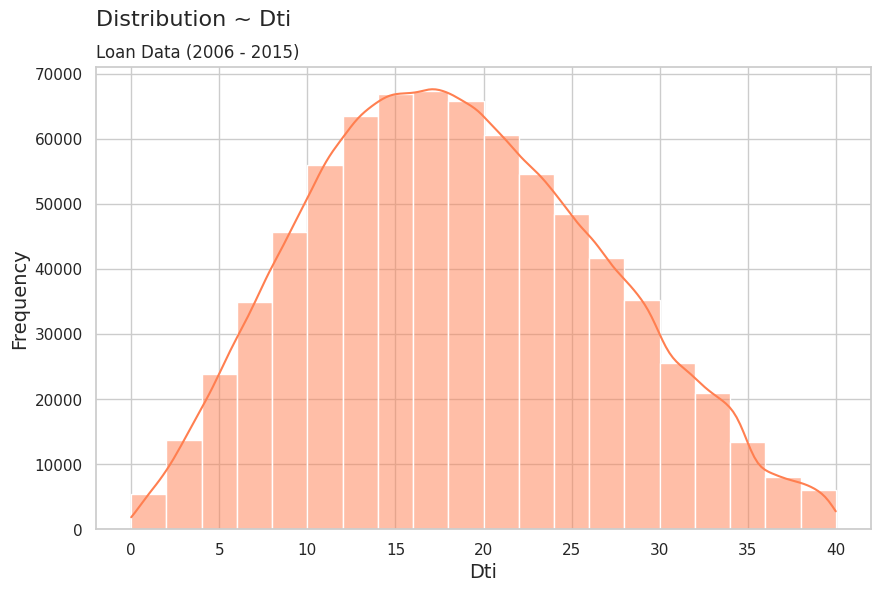

Shapiro-Wilk Test Statistic: 0.98945
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 18.51800742976183,
 'median': 18.04,
 'std_dev': 8.256355811161036,
 'min': 0.0,
 'max': 39.99,
 'coefficient_of_variation': 0.44585551887680747,
 'shapiro_wilk_stat': 0.9894503580525421,
 'shapiro_wilk_p_value': 9.430063111112534e-87}

In [15]:
# dti
continuous_variable_analysis(interest_rate_df_eda,'dti')

##### H : Revolving Account Credit Balance (Borrower)

Mean revol_bal: 16653.804881622826
Median revol_bal: 12052.0
Standard Deviation revol_bal: 18754.40848769242
Minimum revol_bal: 0.0
Maximum revol_bal: 814300.0
Coefficient of Variation revol_bal: 1.126133554524082


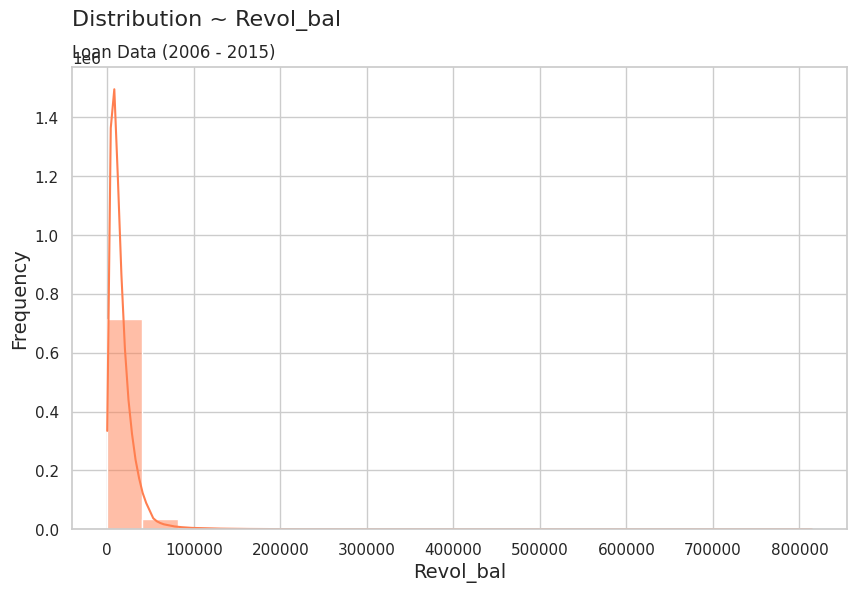

Shapiro-Wilk Test Statistic: 0.59010
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 16653.804881622826,
 'median': 12052.0,
 'std_dev': 18754.40848769242,
 'min': 0.0,
 'max': 814300.0,
 'coefficient_of_variation': 1.126133554524082,
 'shapiro_wilk_stat': 0.590104529612953,
 'shapiro_wilk_p_value': 2.0990910227505263e-199}

In [16]:
# revol_bal
continuous_variable_analysis(interest_rate_df_eda,'revol_bal')

##### I : Revolving Account Credit Used (Borrower)

Mean revol_util: 55.44630333705615
Median revol_util: 56.2
Standard Deviation revol_util: 23.417762347261444
Minimum revol_util: 0.0
Maximum revol_util: 892.3
Coefficient of Variation revol_util: 0.42235029096359555


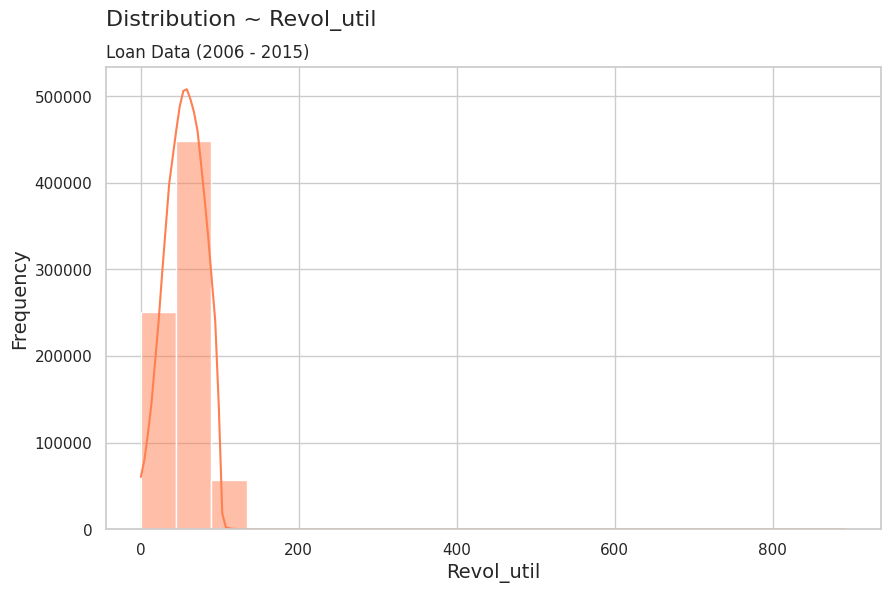

Shapiro-Wilk Test Statistic: 0.98481
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 55.44630333705615,
 'median': 56.2,
 'std_dev': 23.417762347261444,
 'min': 0.0,
 'max': 892.3,
 'coefficient_of_variation': 0.42235029096359555,
 'shapiro_wilk_stat': 0.9848052090318515,
 'shapiro_wilk_p_value': 7.032358226390015e-96}

In [17]:
# revol_util
continuous_variable_analysis(interest_rate_df_eda,'revol_util')

##### J : Principal Outstanding (Borrower Remaining Principal)



Mean out_prncp: 9098.549001708261
Median out_prncp: 7597.47
Standard Deviation out_prncp: 8448.137463665224
Minimum out_prncp: 0.0
Maximum out_prncp: 35000.0
Coefficient of Variation out_prncp: 0.9285148062706567


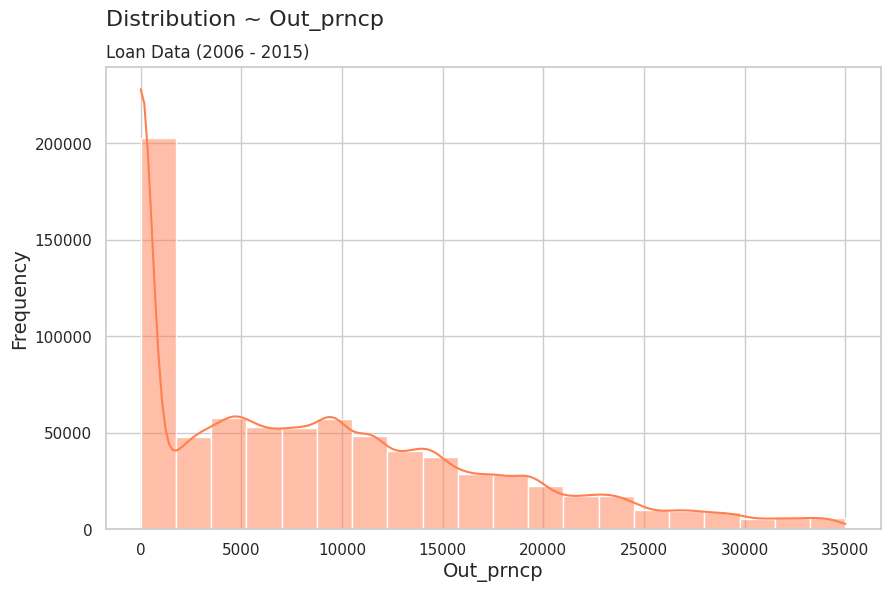

Shapiro-Wilk Test Statistic: 0.90431
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 9098.549001708261,
 'median': 7597.47,
 'std_dev': 8448.137463665224,
 'min': 0.0,
 'max': 35000.0,
 'coefficient_of_variation': 0.9285148062706567,
 'shapiro_wilk_stat': 0.9043146705423831,
 'shapiro_wilk_p_value': 5.214347574391705e-149}

In [18]:
# out_prncp
continuous_variable_analysis(interest_rate_df_eda,'out_prncp')

##### K : Principal Outstanding (Remaining Principal to Investor)

Mean out_prncp_inv: 9094.936791010889
Median out_prncp_inv: 7593.66
Standard Deviation out_prncp_inv: 8444.668660579533
Minimum out_prncp_inv: 0.0
Maximum out_prncp_inv: 35000.0
Coefficient of Variation out_prncp_inv: 0.9285021825468807


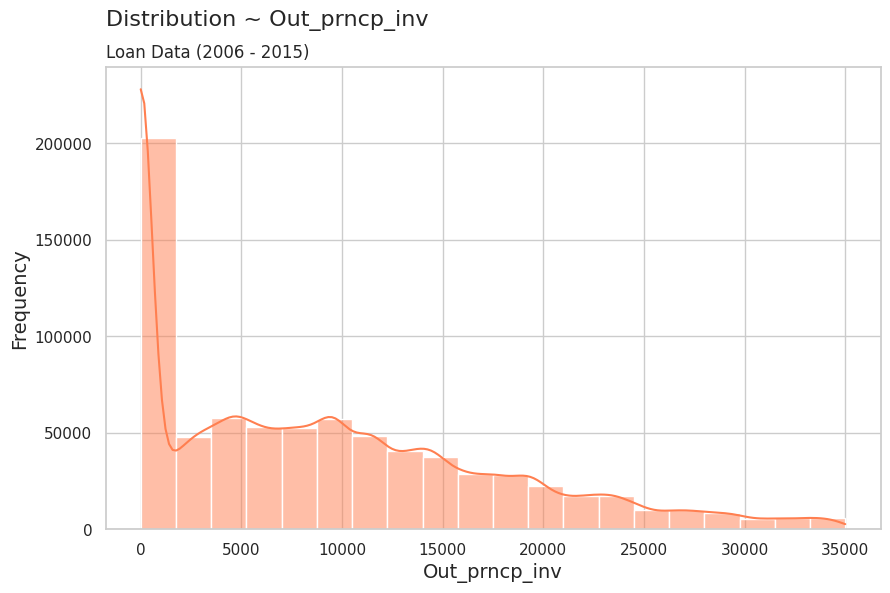

Shapiro-Wilk Test Statistic: 0.90432
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 9094.936791010889,
 'median': 7593.66,
 'std_dev': 8444.668660579533,
 'min': 0.0,
 'max': 35000.0,
 'coefficient_of_variation': 0.9285021825468807,
 'shapiro_wilk_stat': 0.9043162029010139,
 'shapiro_wilk_p_value': 5.22052207879471e-149}

In [19]:
# out_prncp_inv
continuous_variable_analysis(interest_rate_df_eda,'out_prncp_inv')

##### L : Total Payments (By Borrower)

Mean total_pymnt: 7115.461666636186
Median total_pymnt: 4523.610000000001
Standard Deviation total_pymnt: 7521.130235409092
Minimum total_pymnt: 0.0
Maximum total_pymnt: 56087.909922
Coefficient of Variation total_pymnt: 1.0570122625598635


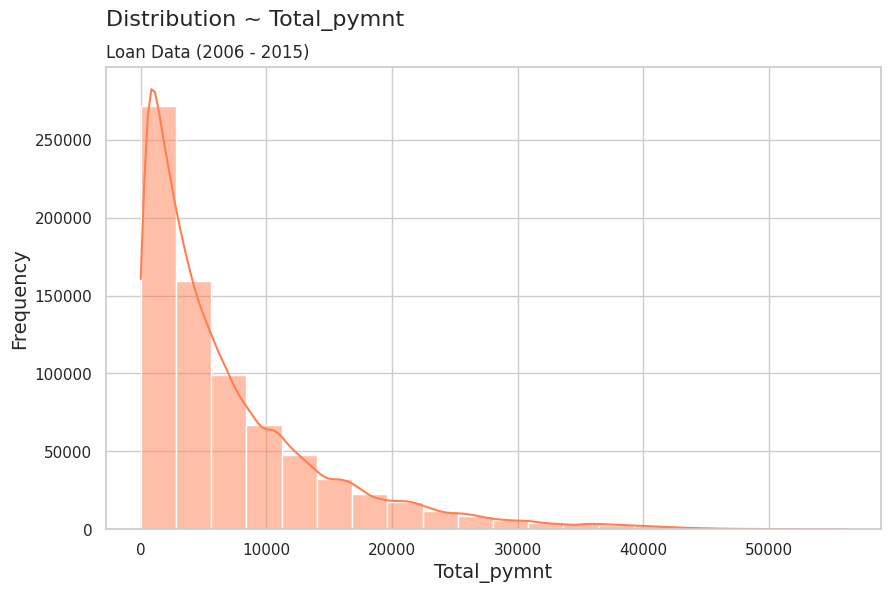

Shapiro-Wilk Test Statistic: 0.80538
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 7115.461666636186,
 'median': 4523.610000000001,
 'std_dev': 7521.130235409092,
 'min': 0.0,
 'max': 56087.909922,
 'coefficient_of_variation': 1.0570122625598635,
 'shapiro_wilk_stat': 0.8053776225227691,
 'shapiro_wilk_p_value': 1.1191690457903942e-172}

In [20]:
# total_pymnt
continuous_variable_analysis(interest_rate_df_eda,'total_pymnt')

##### M : Total Payments (To Investor)

Mean total_pymnt_inv: 7112.268232844091
Median total_pymnt_inv: 4522.19
Standard Deviation total_pymnt_inv: 7517.332429251577
Minimum total_pymnt_inv: 0.0
Maximum total_pymnt_inv: 56047.85
Coefficient of Variation total_pymnt_inv: 1.0569528852324384


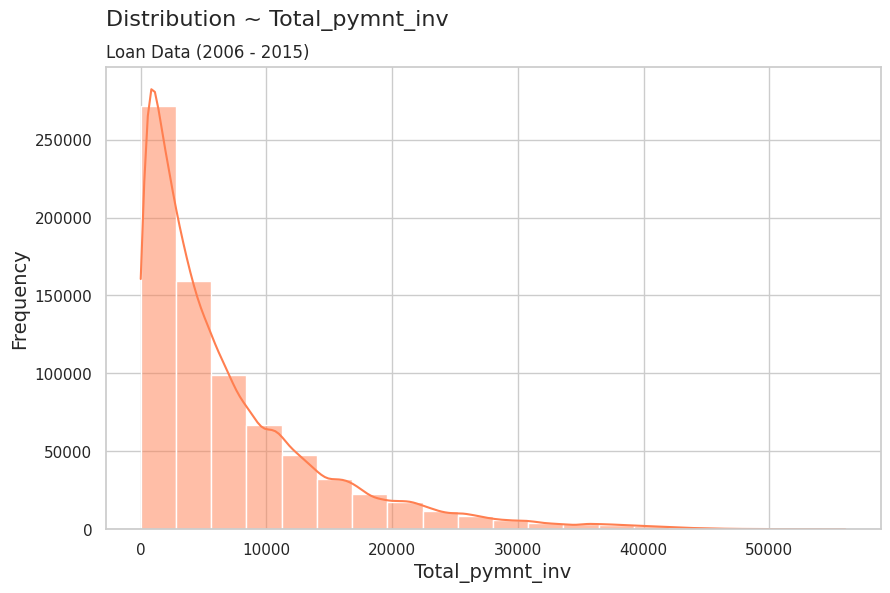

Shapiro-Wilk Test Statistic: 0.80540
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 7112.268232844091,
 'median': 4522.19,
 'std_dev': 7517.332429251577,
 'min': 0.0,
 'max': 56047.85,
 'coefficient_of_variation': 1.0569528852324384,
 'shapiro_wilk_stat': 0.8053956699889837,
 'shapiro_wilk_p_value': 1.127463070328006e-172}

In [21]:
# total_pymnt_inv
continuous_variable_analysis(interest_rate_df_eda,'total_pymnt_inv')

##### N : Total Principal Repaid (Borrower)

Mean total_rec_prncp: 5377.306872490076
Median total_rec_prncp: 2943.88
Standard Deviation total_rec_prncp: 6388.690377531188
Minimum total_rec_prncp: 0.0
Maximum total_rec_prncp: 35000.0
Coefficient of Variation total_rec_prncp: 1.1880836502404724


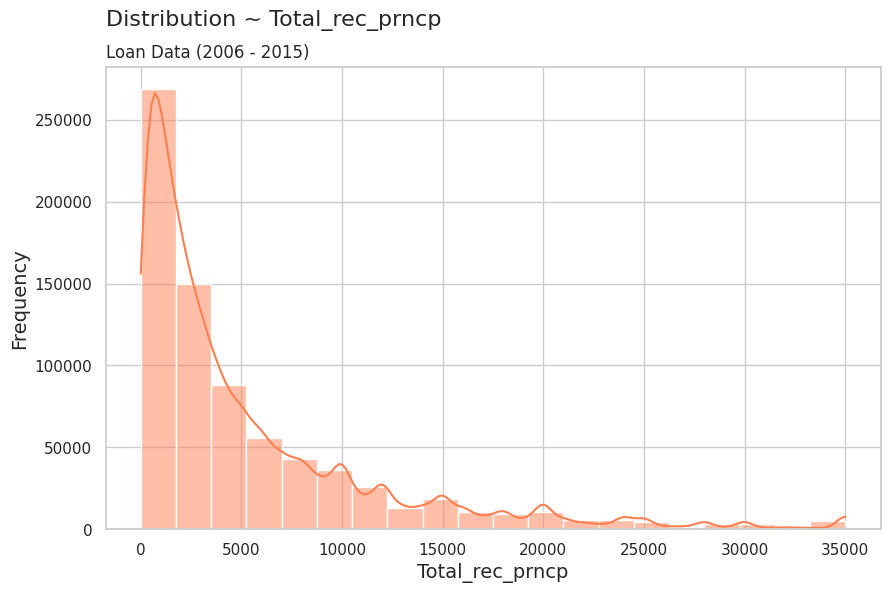

Shapiro-Wilk Test Statistic: 0.75600
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 5377.306872490076,
 'median': 2943.88,
 'std_dev': 6388.690377531188,
 'min': 0.0,
 'max': 35000.0,
 'coefficient_of_variation': 1.1880836502404724,
 'shapiro_wilk_stat': 0.7559980941678456,
 'shapiro_wilk_p_value': 1.3824260859540867e-180}

In [22]:
# total_rec_prncp
continuous_variable_analysis(interest_rate_df_eda,'total_rec_prncp')

##### O : Total Interest Recieved (From Borrower)

Mean total_rec_int: 1697.6044288007556
Median total_rec_int: 1047.395
Standard Deviation total_rec_int: 2001.2523410372253
Minimum total_rec_int: 0.0
Maximum total_rec_int: 21840.0
Coefficient of Variation total_rec_int: 1.178868473176037


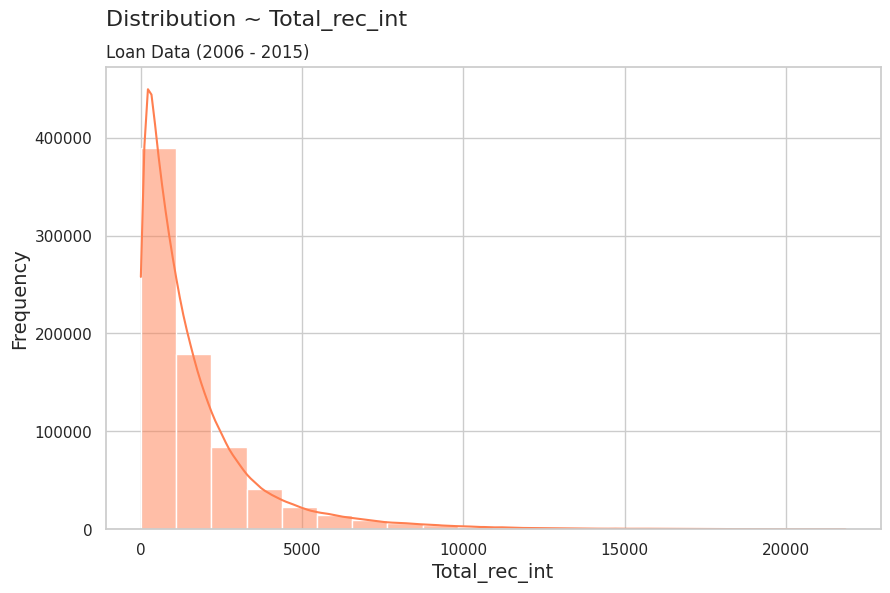

Shapiro-Wilk Test Statistic: 0.72592
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 1697.6044288007556,
 'median': 1047.395,
 'std_dev': 2001.2523410372253,
 'min': 0.0,
 'max': 21840.0,
 'coefficient_of_variation': 1.178868473176037,
 'shapiro_wilk_stat': 0.7259172452078313,
 'shapiro_wilk_p_value': 1.0116618383519952e-184}

In [23]:
# total_rec_int
continuous_variable_analysis(interest_rate_df_eda,'total_rec_int')

##### P : Total Late Fees Collected (From Borrower By Lending Club)

Mean total_rec_late_fee: 0.3192625509517991
Median total_rec_late_fee: 0.0
Standard Deviation total_rec_late_fee: 3.6436689032714327
Minimum total_rec_late_fee: 0.0
Maximum total_rec_late_fee: 358.68
Coefficient of Variation total_rec_late_fee: 11.412766365515692


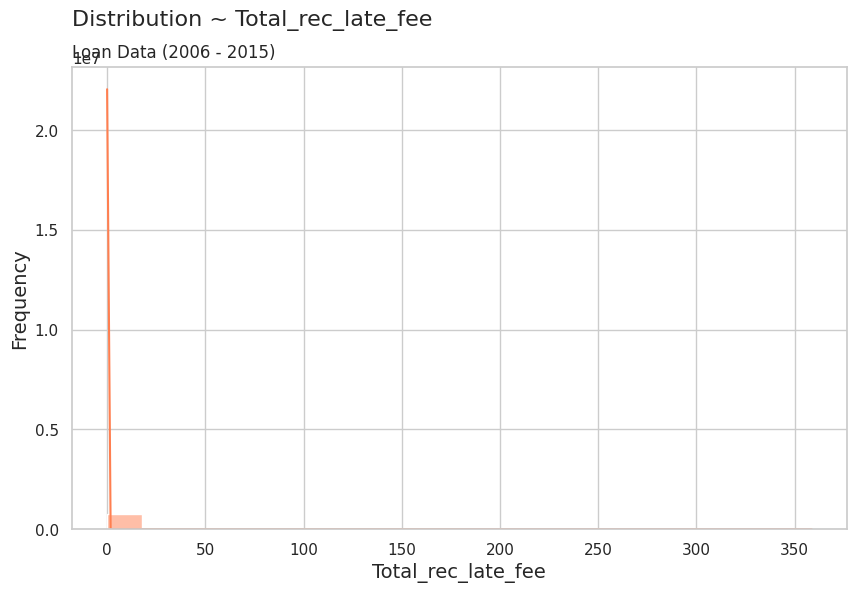

Shapiro-Wilk Test Statistic: 0.06160
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 0.3192625509517991,
 'median': 0.0,
 'std_dev': 3.6436689032714327,
 'min': 0.0,
 'max': 358.68,
 'coefficient_of_variation': 11.412766365515692,
 'shapiro_wilk_stat': 0.06160477567378475,
 'shapiro_wilk_p_value': 2.0902908116562345e-231}

In [24]:
# total_rec_late_fee
continuous_variable_analysis(interest_rate_df_eda,'total_rec_late_fee')

##### Q : Recoveries (From Borrower By Collections Agency)

Mean recoveries: 40.231105183671424
Median recoveries: 0.0
Standard Deviation recoveries: 374.3842451546012
Minimum recoveries: 0.0
Maximum recoveries: 33520.27
Coefficient of Variation recoveries: 9.30584042982126


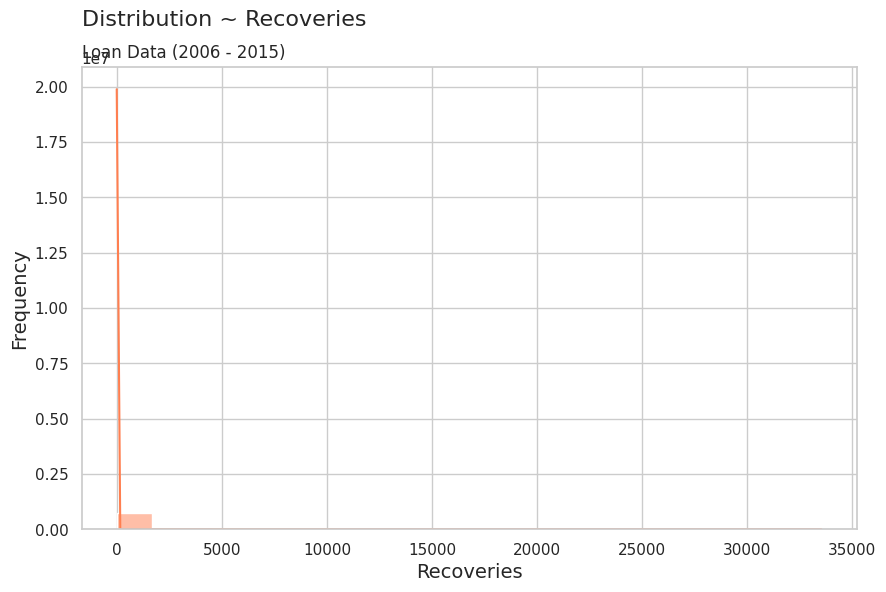

Shapiro-Wilk Test Statistic: 0.08416
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 40.231105183671424,
 'median': 0.0,
 'std_dev': 374.3842451546012,
 'min': 0.0,
 'max': 33520.27,
 'coefficient_of_variation': 9.30584042982126,
 'shapiro_wilk_stat': 0.084162918659905,
 'shapiro_wilk_p_value': 1.970625608176708e-230}

In [25]:
# recoveries
continuous_variable_analysis(interest_rate_df_eda,'recoveries')

##### R : Collection Recovery Fee (Fee Charged By Collections Agency)

Mean collection_recovery_fee: 4.291250490037191
Median collection_recovery_fee: 0.0
Standard Deviation collection_recovery_fee: 52.85637252659761
Minimum collection_recovery_fee: 0.0
Maximum collection_recovery_fee: 5694.0936
Coefficient of Variation collection_recovery_fee: 12.31724240971529


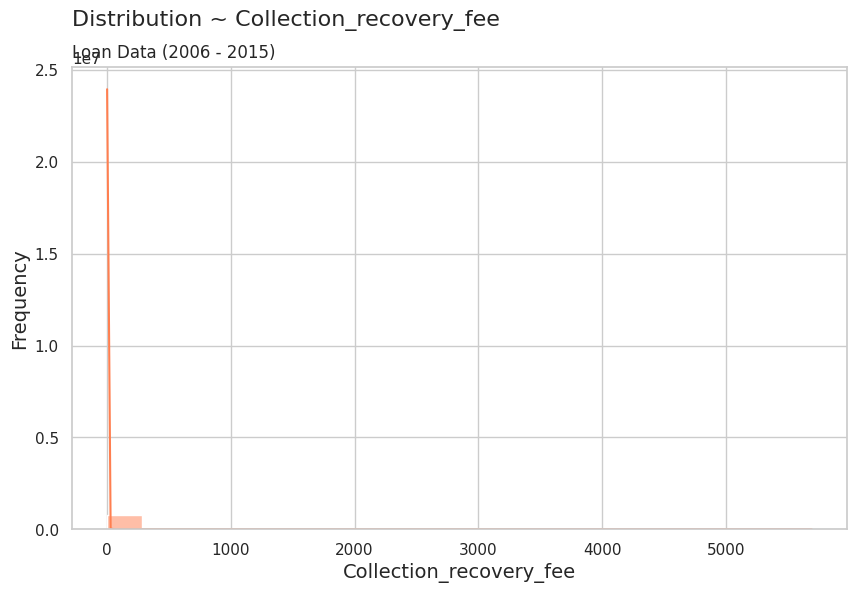

Shapiro-Wilk Test Statistic: 0.05489
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 4.291250490037191,
 'median': 0.0,
 'std_dev': 52.85637252659761,
 'min': 0.0,
 'max': 5694.0936,
 'coefficient_of_variation': 12.31724240971529,
 'shapiro_wilk_stat': 0.054886356893534716,
 'shapiro_wilk_p_value': 1.0817717802502895e-231}

In [26]:
# collection_recovery_fee
continuous_variable_analysis(interest_rate_df_eda,'collection_recovery_fee')

##### S : Last Payment (Recent Payment By Borrower)

Mean last_pymnt_amnt: 2122.563854089933
Median last_pymnt_amnt: 459.67
Standard Deviation last_pymnt_amnt: 4794.821157724178
Minimum last_pymnt_amnt: 0.0
Maximum last_pymnt_amnt: 36475.59
Coefficient of Variation last_pymnt_amnt: 2.25897616624589


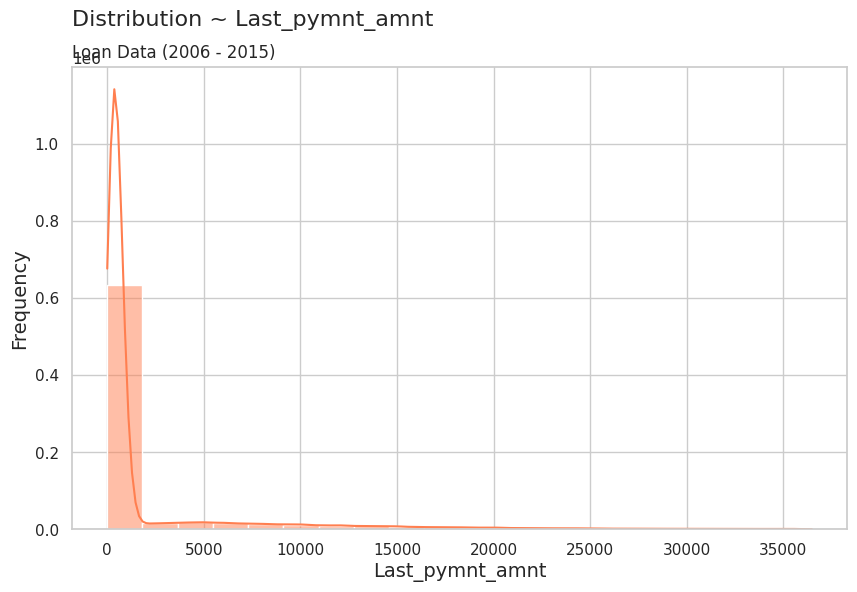

Shapiro-Wilk Test Statistic: 0.45236
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 2122.563854089933,
 'median': 459.67,
 'std_dev': 4794.821157724178,
 'min': 0.0,
 'max': 36475.59,
 'coefficient_of_variation': 2.25897616624589,
 'shapiro_wilk_stat': 0.45235915935461357,
 'shapiro_wilk_p_value': 2.5201459869081547e-210}

In [27]:
continuous_variable_analysis(interest_rate_df_eda,'last_pymnt_amnt')

##### T : Total Collections Amount (Unpaid Debt Sent To Collections Agency)

Mean tot_coll_amt: 221.81563286309859
Median tot_coll_amt: 0.0
Standard Deviation tot_coll_amt: 10690.160646232427
Minimum tot_coll_amt: 0.0
Maximum tot_coll_amt: 9152545.0
Coefficient of Variation tot_coll_amt: 48.19390098095674


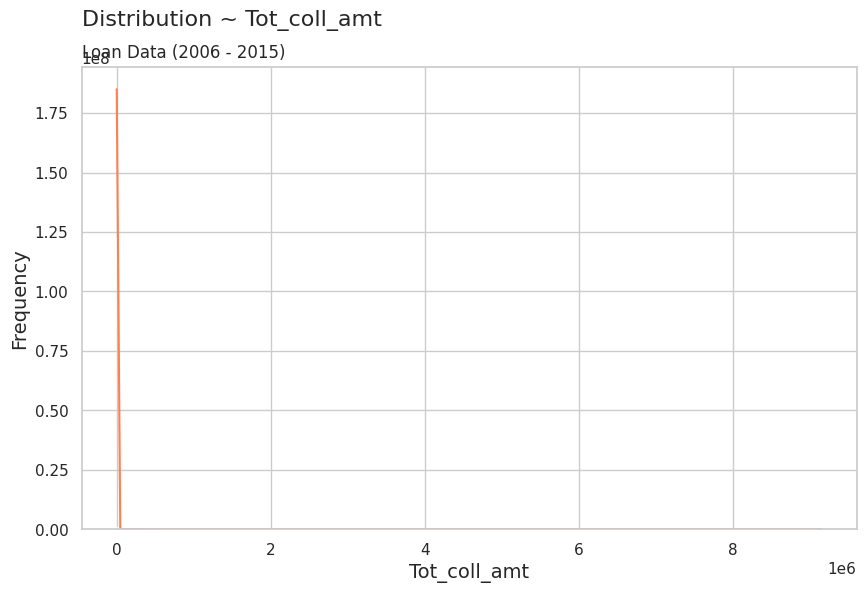

Shapiro-Wilk Test Statistic: 0.00303
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 221.81563286309859,
 'median': 0.0,
 'std_dev': 10690.160646232427,
 'min': 0.0,
 'max': 9152545.0,
 'coefficient_of_variation': 48.19390098095674,
 'shapiro_wilk_stat': 0.0030304602005457593,
 'shapiro_wilk_p_value': 7.700823555917008e-234}

In [28]:
# tot_coll_amt
continuous_variable_analysis(interest_rate_df_eda,'tot_coll_amt')

##### U : Current Balance (Borrower Credit Accounts)

Mean tot_cur_bal: 136352.28883925153
Median tot_cur_bal: 81287.0
Standard Deviation tot_cur_bal: 140003.89637179975
Minimum tot_cur_bal: 0.0
Maximum tot_cur_bal: 3610743.0
Coefficient of Variation tot_cur_bal: 1.0267806837980782


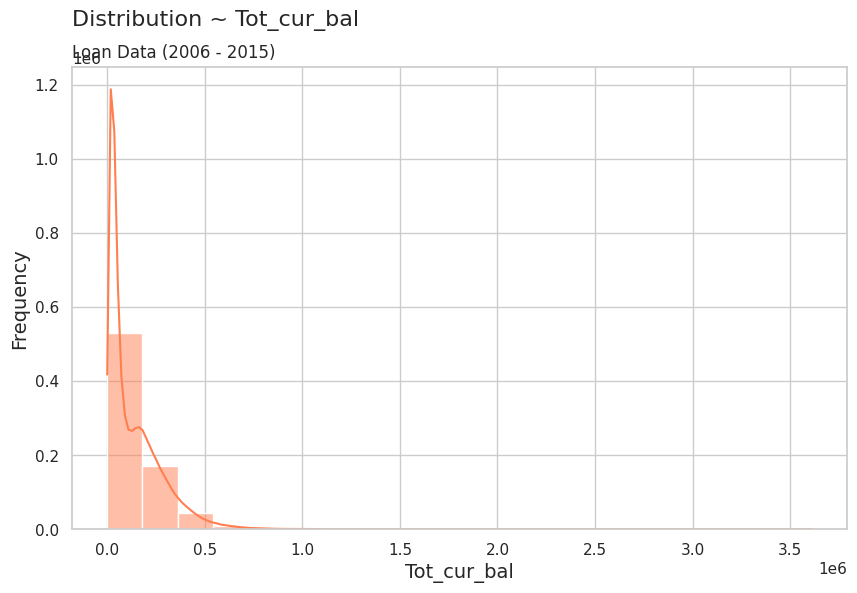

Shapiro-Wilk Test Statistic: 0.82170
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 136352.28883925153,
 'median': 81287.0,
 'std_dev': 140003.89637179975,
 'min': 0.0,
 'max': 3610743.0,
 'coefficient_of_variation': 1.0267806837980782,
 'shapiro_wilk_stat': 0.8217018538465274,
 'shapiro_wilk_p_value': 1.160620455655783e-169}

In [29]:
# tot_cur_bal
continuous_variable_analysis(interest_rate_df_eda,'tot_cur_bal')

##### V : Highest Credit Limit (Borrower Revolving Credit Accounts)

Mean total_rev_hi_lim: 31308.165969631442
Median total_rev_hi_lim: 23600.0
Standard Deviation total_rev_hi_lim: 29002.80314185616
Minimum total_rev_hi_lim: 0.0
Maximum total_rev_hi_lim: 1119200.0
Coefficient of Variation total_rev_hi_lim: 0.9263654463180162


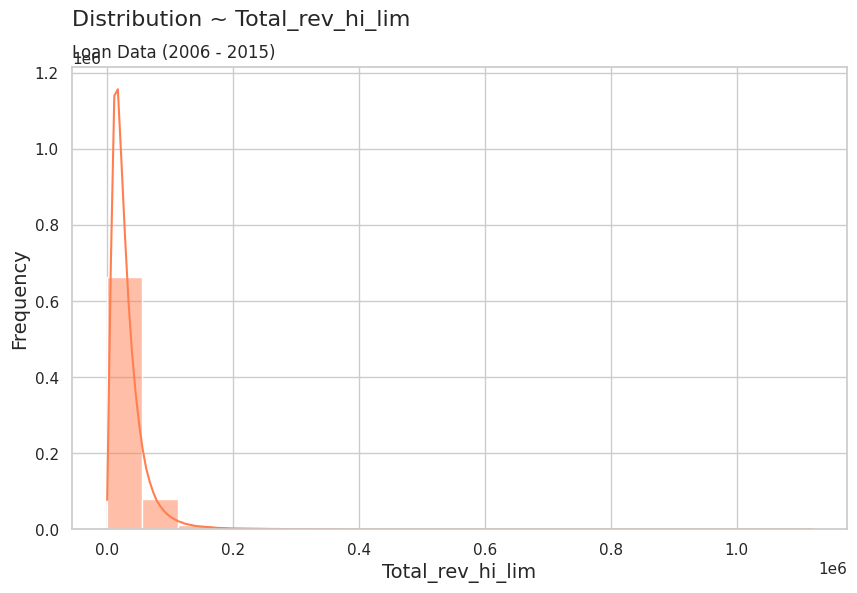

Shapiro-Wilk Test Statistic: 0.70101
p-value: 0.00000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 757494.
  res = hypotest_fun_out(*samples, **kwds)


{'mean': 31308.165969631442,
 'median': 23600.0,
 'std_dev': 29002.80314185616,
 'min': 0.0,
 'max': 1119200.0,
 'coefficient_of_variation': 0.9263654463180162,
 'shapiro_wilk_stat': 0.7010113885232034,
 'shapiro_wilk_p_value': 7.586437747589953e-188}

In [30]:
# total_rev_hi_lim
continuous_variable_analysis(interest_rate_df_eda,'total_rev_hi_lim')

##### 1.1.5 Analyse the distribution of discrete variables

In [31]:
print(discrete_vars)
print(len(discrete_vars)) # 8 discrete variables

Index(['emp_length', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq'],
      dtype='object')
8


##### A : Employment Length

emp_length
10    268070
2      70149
3      62227
0      62169
1      50774
5      48562
4      45579
7      40282
8      40274
6      37732
9      31676
Name: count, dtype: int64
emp_length
10    0.353891
2     0.092607
3     0.082149
0     0.082072
1     0.067029
5     0.064109
4     0.060171
7     0.053178
8     0.053167
6     0.049812
9     0.041817
Name: proportion, dtype: float64


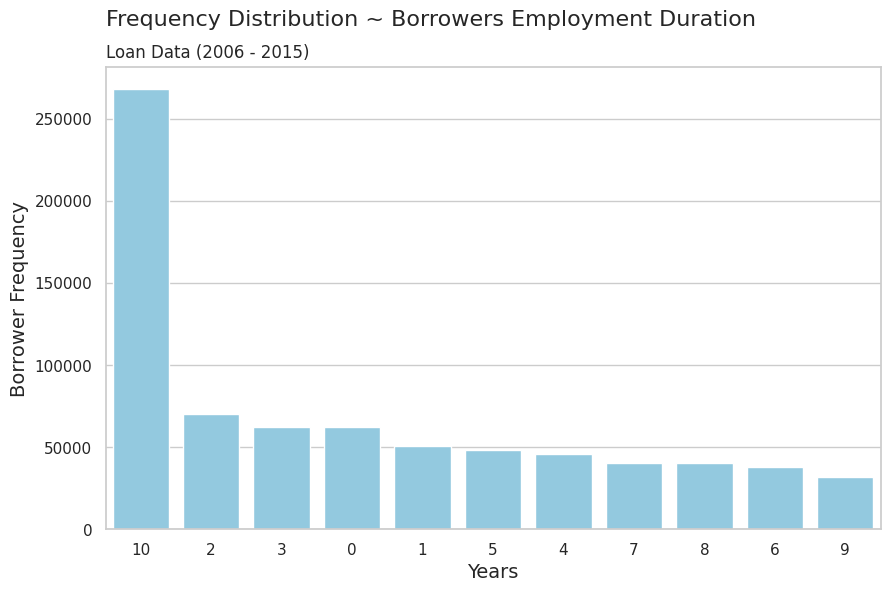

In [32]:
# Frequency Distribution of Discrete Variables

# Employment Length
print(interest_rate_df_eda['emp_length'].value_counts())

# Returns the proportion of borrowers for each length of employment
print(interest_rate_df_eda['emp_length'].value_counts(normalize = True))

# Frequency Distribution of Employment Length
sns.set(style = "whitegrid")
plt.figure(figsize = (10,6))
ax = sns.countplot(data = interest_rate_df_eda,x = 'emp_length',order = interest_rate_df_eda['emp_length'].value_counts().index,color = "skyblue")
plt.title('Frequency Distribution ~ Borrowers Employment Duration',fontsize = 16,loc = 'left',pad = 30)
plt.text(0,1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
plt.xlabel('Years',fontsize = 14)
plt.ylabel('Borrower Frequency',fontsize = 14)
plt.show()

##### B : Borrower Delinquencies (Last 2 Years) and Credit Inquires (Last 6 months)

delinq_2yrs
0     605979
1     100027
2      30082
3      10820
4       4840
5       2473
6       1328
7        711
8        428
9        254
10       173
11       111
12        86
13        57
14        44
15        26
16        16
18        11
17         9
19         5
22         3
20         2
26         2
21         2
24         1
29         1
30         1
27         1
39         1
Name: count, dtype: int64
delinq_2yrs
0     0.799979
1     0.132050
2     0.039713
3     0.014284
4     0.006389
5     0.003265
6     0.001753
7     0.000939
8     0.000565
9     0.000335
10    0.000228
11    0.000147
12    0.000114
13    0.000075
14    0.000058
15    0.000034
16    0.000021
18    0.000015
17    0.000012
19    0.000007
22    0.000004
20    0.000003
26    0.000003
21    0.000003
24    0.000001
29    0.000001
30    0.000001
27    0.000001
39    0.000001
Name: proportion, dtype: float64
inq_last_6mths
0    431114
1    206176
2     77861
3     29807
4      8702
5      3035
6       795
7     

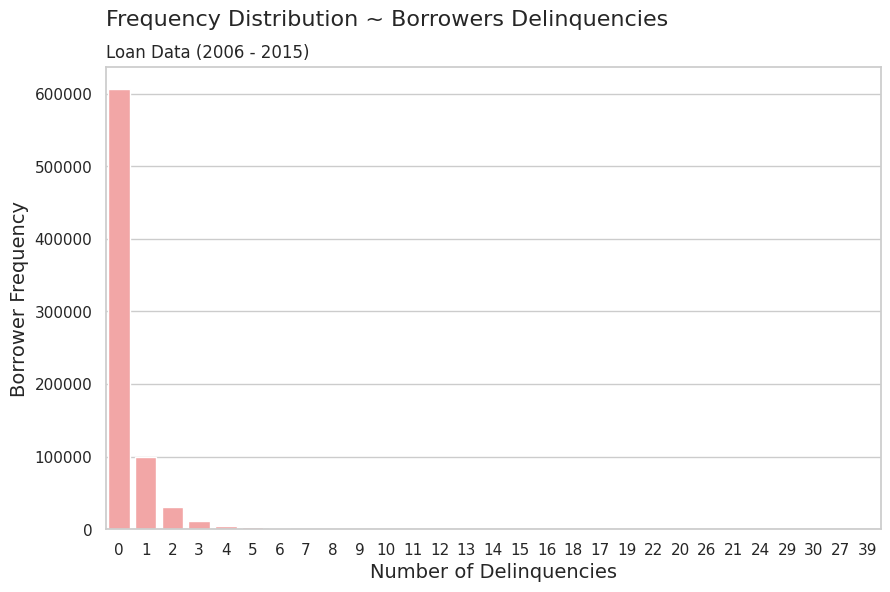

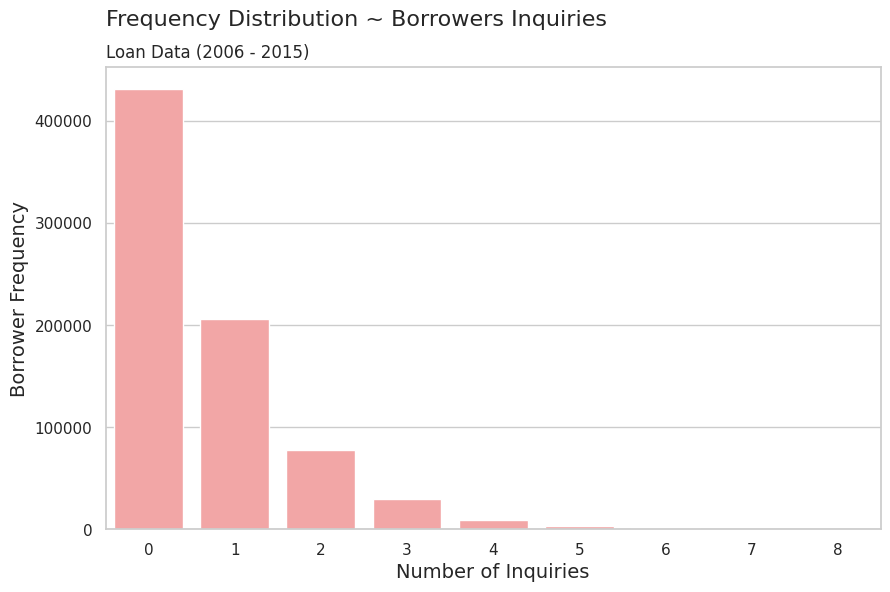

In [33]:
# Borrower Delinquencies over the last 2 years and Inquiries in the last 6 months
# delinq_2yrs
# inq_last_6mths

# Frequency Distribution of (Delinquencies : 2 Years)
print(interest_rate_df_eda['delinq_2yrs'].value_counts())

# Proportion of borrowers that have had delinquencies (30 plus days of past due payments)
print(interest_rate_df_eda['delinq_2yrs'].value_counts(normalize = True))

# Frequency Distribution of (Inquires : Last 6 months)
print(interest_rate_df_eda['inq_last_6mths'].value_counts())

# Proportion of borrowers that have had inquiries in the last 6 months
print(interest_rate_df_eda['inq_last_6mths'].value_counts(normalize = True))

# Frequency Distribution of (Delinquencies : last 2 years)
sns.set(style = "whitegrid")
plt.figure(figsize = (10,6))
ax = sns.countplot(data = interest_rate_df_eda,x = 'delinq_2yrs',order = interest_rate_df_eda['delinq_2yrs'].value_counts().index,color = "#FF9999")
plt.title('Frequency Distribution ~ Borrowers Delinquencies',fontsize = 16,loc = 'left',pad = 30)
plt.text(0,1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
plt.xlabel('Number of Delinquencies',fontsize = 14)
plt.ylabel('Borrower Frequency',fontsize = 14)
plt.show()

# Frequency Distribution of (Inquires : Last 6 months)
sns.set(style = "whitegrid")
plt.figure(figsize = (10,6))
ax = sns.countplot(data = interest_rate_df_eda,x = 'inq_last_6mths',order = interest_rate_df_eda['inq_last_6mths'].value_counts().index,color = "#FF9999")
plt.title('Frequency Distribution ~ Borrowers Inquiries',fontsize = 16,loc = 'left',pad = 30)
plt.text(0,1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
plt.xlabel('Number of Inquiries',fontsize = 14)
plt.ylabel('Borrower Frequency',fontsize = 14)
plt.show()

##### C : Public Derogatory Records (Bankruptcies, Judgements etc.), Collections (Last 12 Months excl. Medical Debts) and Current Delinquencies

In [34]:
# Number of public derogatory records, collections over the last 12 months and current delinquent accounts
# pub_rec
# collections_12_mths_ex_med
# acc_now_delinq

# Frequency Distribution of Public Derogatory Records
print(interest_rate_df_eda['pub_rec'].value_counts())

# Proportion of Borrowers that have had a signficant negative mark (for e.g. bankruptcies)
print(interest_rate_df_eda['pub_rec'].value_counts(normalize = True))

# Frequency Distribution of Collections (Last 12 months)
print(interest_rate_df_eda['collections_12_mths_ex_med'].value_counts())

# Proportion of Borrowers that have had collections (Last 12 months) # This excludes medical debts.
print(interest_rate_df_eda['collections_12_mths_ex_med'].value_counts(normalize = True))

# Frequency Distribution of Current Delinquencies
print(interest_rate_df_eda['acc_now_delinq'].value_counts())

# Proportion of Borrowers that have Current delinquencies (Current)
print(interest_rate_df_eda['acc_now_delinq'].value_counts(normalize = True))

pub_rec
0     638471
1      99185
2      13159
3       3970
4       1364
5        643
6        314
7        142
8         91
9         44
10        33
11        19
12        15
13        12
15         5
18         4
17         3
16         3
21         2
49         2
19         2
54         1
63         1
40         1
23         1
34         1
26         1
28         1
86         1
20         1
14         1
22         1
Name: count, dtype: int64
pub_rec
0     0.842873
1     0.130938
2     0.017372
3     0.005241
4     0.001801
5     0.000849
6     0.000415
7     0.000187
8     0.000120
9     0.000058
10    0.000044
11    0.000025
12    0.000020
13    0.000016
15    0.000007
18    0.000005
17    0.000004
16    0.000004
21    0.000003
49    0.000003
19    0.000003
54    0.000001
63    0.000001
40    0.000001
23    0.000001
34    0.000001
26    0.000001
28    0.000001
86    0.000001
20    0.000001
14    0.000001
22    0.000001
Name: proportion, dtype: float64
collections_12_mths_ex_med
0 

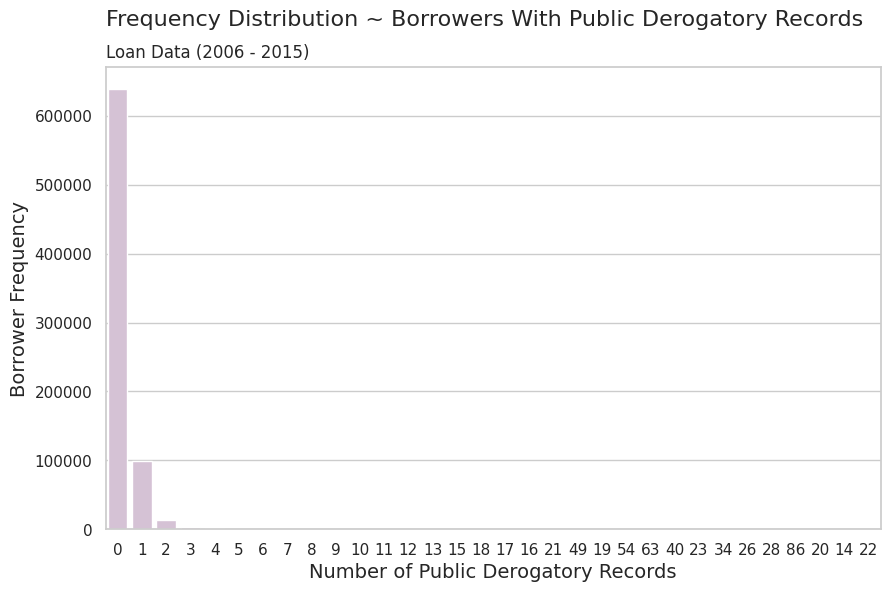

<Figure size 640x480 with 0 Axes>

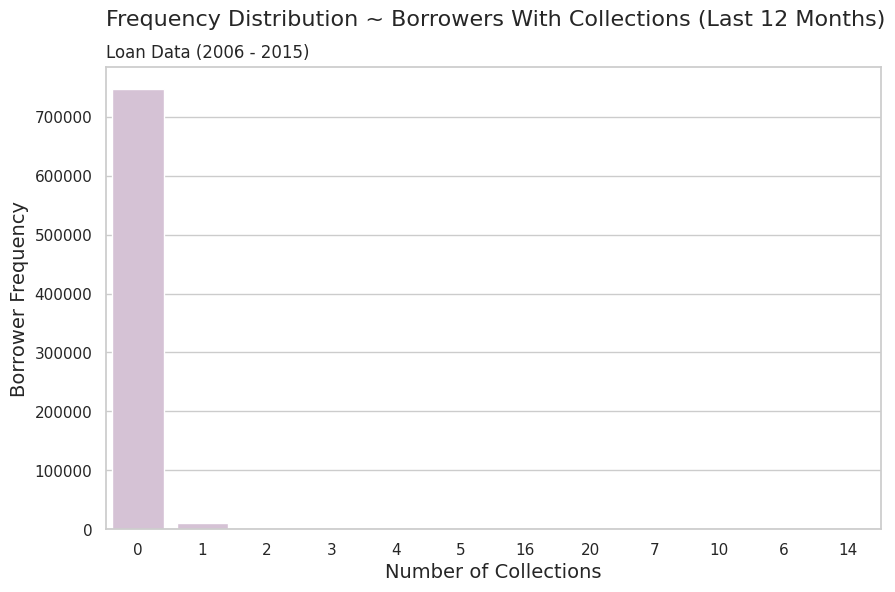

<Figure size 640x480 with 0 Axes>

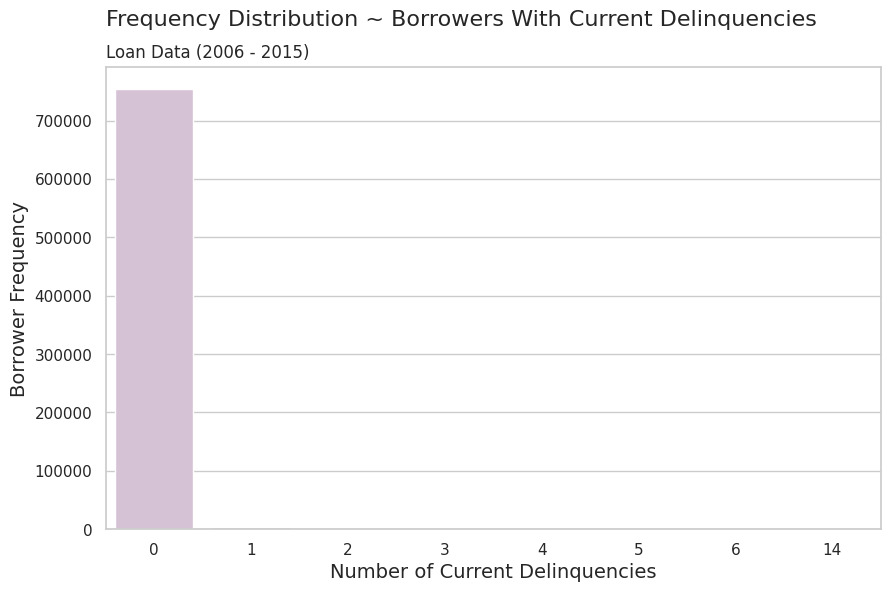

In [35]:
# Frequency Distribution of Public Derogatory Records
sns.set(style = "whitegrid")
plt.figure(figsize = (10,6))
ax = sns.countplot(data = interest_rate_df_eda,x = 'pub_rec',order = interest_rate_df_eda['pub_rec'].value_counts().index,color = "Thistle")
plt.title('Frequency Distribution ~ Borrowers With Public Derogatory Records',fontsize = 16,loc = 'left',pad = 30)
plt.text(0,1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
plt.xlabel('Number of Public Derogatory Records',fontsize = 14)
plt.ylabel('Borrower Frequency',fontsize = 14)
plt.show()
plt.clf()

# Frequency Distribution of Collections (Last 12 Months)
sns.set(style = "whitegrid")
plt.figure(figsize = (10,6))
ax = sns.countplot(data = interest_rate_df_eda,x = 'collections_12_mths_ex_med',order = interest_rate_df_eda['collections_12_mths_ex_med'].value_counts().index,color = "Thistle")
plt.title('Frequency Distribution ~ Borrowers With Collections (Last 12 Months)',fontsize = 16,loc = 'left',pad = 30)
plt.text(0,1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
plt.xlabel('Number of Collections',fontsize = 14)
plt.ylabel('Borrower Frequency',fontsize = 14)
plt.show()
plt.clf()

# Frequency Distribution of Current Delinquencies
sns.set(style = "whitegrid")
plt.figure(figsize = (10,6))
ax = sns.countplot(data = interest_rate_df_eda,x = 'acc_now_delinq',order = interest_rate_df_eda['acc_now_delinq'].value_counts().index,color = "Thistle")
plt.title('Frequency Distribution ~ Borrowers With Current Delinquencies',fontsize = 16,loc = 'left',pad = 30)
plt.text(0,1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
plt.xlabel('Number of Current Delinquencies',fontsize = 14)
plt.ylabel('Borrower Frequency',fontsize = 14)
plt.show()

##### D : Account Information (Borrower Active Accounts and Total Accounts)

open_acc
9     68155
10    67137
8     64326
11    62446
12    56252
      ...  
64        1
79        1
59        1
74        1
90        1
Name: count, Length: 77, dtype: int64
open_acc
9     0.089974
10    0.088630
8     0.084919
11    0.082438
12    0.074261
        ...   
64    0.000001
79    0.000001
59    0.000001
74    0.000001
90    0.000001
Name: proportion, Length: 77, dtype: float64
total_acc
22     27778
20     27508
21     27379
19     27083
23     26973
       ...  
127        1
125        1
138        1
162        1
114        1
Name: count, Length: 133, dtype: int64
total_acc
22     0.036671
20     0.036314
21     0.036144
19     0.035753
23     0.035608
         ...   
127    0.000001
125    0.000001
138    0.000001
162    0.000001
114    0.000001
Name: proportion, Length: 133, dtype: float64


<ipython-input-36-fb4b56af325a>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 45,horizontalalignment = 'right')


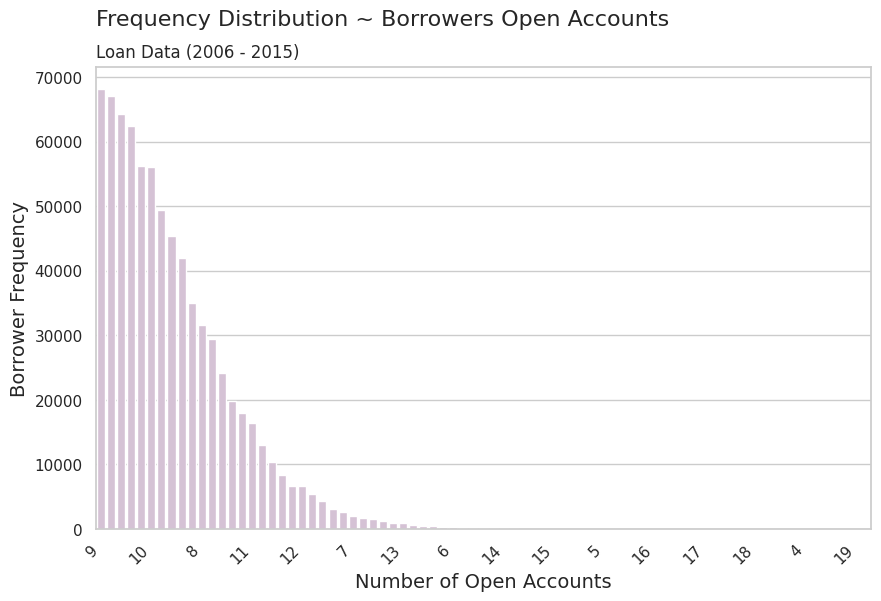

<ipython-input-36-fb4b56af325a>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation = 45,horizontalalignment = 'right')


<Figure size 640x480 with 0 Axes>

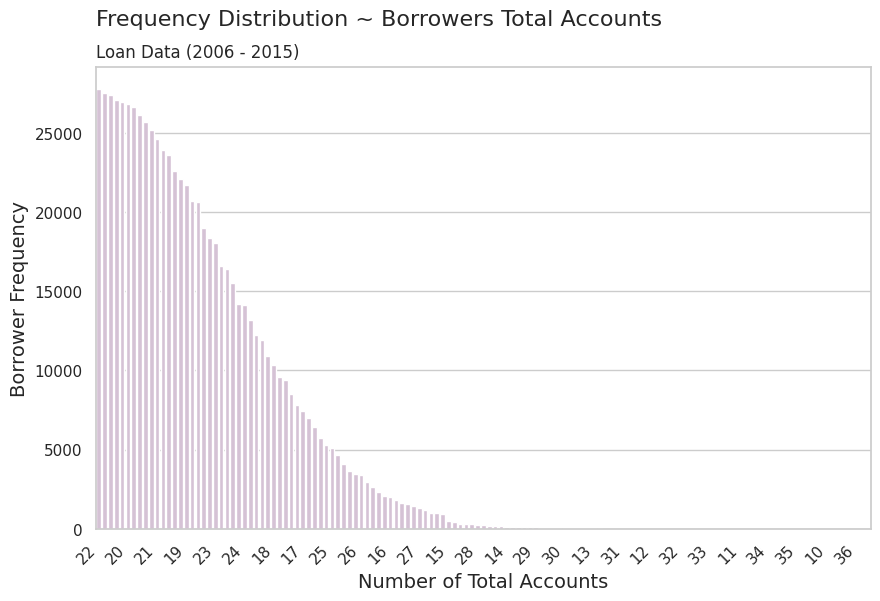

In [36]:
# Number of active credit accounts and total accounts (open and closed)
# open_acc
# total_acc

# Frequency Distribution of Open (Active) Accounts
print(interest_rate_df_eda['open_acc'].value_counts())

# Proportion of current accounts of borrowers that are active
print(interest_rate_df_eda['open_acc'].value_counts(normalize = True))

# Frequency Distribution of Total Accounts
print(interest_rate_df_eda['total_acc'].value_counts())

# Proportion of open/closed accounts of borrowers
print(interest_rate_df_eda['total_acc'].value_counts(normalize = True))

# Frequency Distribution for open (active) and total accounts (open/closed)

# Open (Active) Accounts
sns.set(style = "whitegrid")
plt.figure(figsize = (10,6))
ax = sns.countplot(data = interest_rate_df_eda,x = 'open_acc',order = interest_rate_df_eda['open_acc'].value_counts().index,color = "Thistle")
plt.title('Frequency Distribution ~ Borrowers Open Accounts',fontsize = 16,loc = 'left',pad = 30)
plt.text(0,1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
plt.xlabel('Number of Open Accounts',fontsize = 14)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45,horizontalalignment = 'right')
ax.set_xticks(ax.get_xticks()[::5]) # Every fifth label is displayed
plt.ylabel('Borrower Frequency',fontsize = 14)
plt.show()
plt.clf()

# Total Accounts (Open/Closed)
sns.set(style = "whitegrid")
plt.figure(figsize = (10,6))
ax = sns.countplot(data = interest_rate_df_eda,x = 'total_acc',order = interest_rate_df_eda['total_acc'].value_counts().index,color = "Thistle")
plt.title('Frequency Distribution ~ Borrowers Total Accounts',fontsize = 16,loc = 'left',pad = 30)
plt.text(0,1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
plt.xlabel('Number of Total Accounts',fontsize = 14)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45,horizontalalignment = 'right')
ax.set_xticks(ax.get_xticks()[::5]) # Every fifth label is displayed
plt.ylabel('Borrower Frequency',fontsize = 14)
plt.show()

In [37]:
print(continuous_vars)
print(discrete_vars)

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'revol_bal', 'revol_util',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim'],
      dtype='object')
Index(['emp_length', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq'],
      dtype='object')


##### 1.1.6 Identify Signficant Correlations with Interest Rates

##### A : Continuous Variables

loan_amnt  funded_amnt  funded_amnt_inv  int_rate  \
loan_amnt                 1.000000     1.000000         0.999994  0.137239   
funded_amnt               1.000000     1.000000         0.999995  0.137239   
funded_amnt_inv           0.999994     0.999995         1.000000  0.137133   
int_rate                  0.137239     0.137239         0.137133  1.000000   
installment               0.943200     0.943201         0.943186  0.123612   
annual_inc                0.478945     0.478944         0.479007 -0.125636   
dti                       0.048830     0.048830         0.048747  0.159259   
revol_bal                 0.366125     0.366125         0.366114 -0.046289   
revol_util                0.120300     0.120301         0.120227  0.249077   
out_prncp                 0.666822     0.666822         0.666867  0.036649   
out_prncp_inv             0.666830     0.666831         0.666882  0.036497   
total_pymnt               0.465099     0.465099         0.465044  0.173773   
total_pymnt_inv           0.465144     0.465143         0.465094  0.173849   
total_rec_prncp           0.376349     0.376348         0.376283  0.057238   
total_rec_int             0.533251     0.533251         0.533256  0.449991   
total_rec_late_fee        0.036182     0.036182         0.036177  0.058217   
recoveries                0.070504     0.070504         0.070489  0.108270   
collection_recovery_fee   0.058037     0.058038         0.058027  0.079860   
last_pymnt_amnt           0.215879     0.215879         0.215864  0.100752   
tot_coll_amt             -0.004135    -0.004135        -0.004134  0.001160   
tot_cur_bal               0.311794     0.311794         0.311812 -0.090332   
total_rev_hi_lim          0.367287     0.367285         0.367326 -0.201566   

                         installment  annual_inc       dti  revol_bal  \
loan_amnt                   0.943200    0.478945  0.048830   0.366125   
funded_amnt                 0.943201    0.478944  0.048830   0.366125   
funded_amnt_inv             0.943186    0.479007  0.048747   0.366114   
int_rate                    0.123612   -0.125636  0.159259  -0.046289   
installment                 1.000000    0.460708  0.033535   0.341653   
annual_inc                  0.460708    1.000000 -0.219534   0.365757   
dti                         0.033535   -0.219534  1.000000   0.181211   
revol_bal                   0.341653    0.365757  0.181211   1.000000   
revol_util                  0.130216    0.061048  0.168500   0.249064   
out_prncp                   0.560568    0.311610  0.103180   0.259413   
out_prncp_inv               0.560566    0.311668  0.103096   0.259419   
total_pymnt                 0.511938    0.227984 -0.060174   0.150848   
total_pymnt_inv             0.511987    0.228020 -0.060180   0.150849   
total_rec_prncp             0.441564    0.209996 -0.082494   0.128457   
total_rec_int               0.500430    0.184174  0.035736   0.154442   
total_rec_late_fee          0.046689    0.019722 -0.000586   0.002779   
recoveries                  0.073929    0.011870  0.007846   0.012786   
collection_recovery_fee     0.060853    0.011676  0.010780   0.011878   
last_pymnt_amnt             0.229352    0.125915 -0.053659   0.059497   
tot_coll_amt               -0.003438    0.002495 -0.004346  -0.006768   
tot_cur_bal                 0.275284    0.524034  0.015766   0.397147   
total_rev_hi_lim            0.332086    0.371982  0.112704   0.814728   

                         revol_util  out_prncp  ...  total_pymnt_inv  \
loan_amnt                  0.120300   0.666822  ...         0.465144   
funded_amnt                0.120301   0.666822  ...         0.465143   
funded_amnt_inv            0.120227   0.666867  ...         0.465094   
int_rate                   0.249077   0.036649  ...         0.173849   
installment                0.130216   0.560568  ...         0.511987   
annual_inc                 0.061048   0.311610  ...         0.228020   
dti                        0.168500   0.103180

int_rate                   1.000000
total_rec_int              0.449991
revol_util                 0.249077
total_pymnt_inv            0.173849
total_pymnt                0.173773
dti                        0.159259
funded_amnt                0.137239
loan_amnt                  0.137239
funded_amnt_inv            0.137133
installment                0.123612
recoveries                 0.108270
last_pymnt_amnt            0.100752
collection_recovery_fee    0.079860
total_rec_late_fee         0.058217
total_rec_prncp            0.057238
out_prncp                  0.036649
out_prncp_inv              0.036497
tot_coll_amt               0.001160
revol_bal                 -0.046289
tot_cur_bal               -0.090332
annual_inc                -0.125636
total_rev_hi_lim          -0.201566
Name: int_rate, dtype: float64

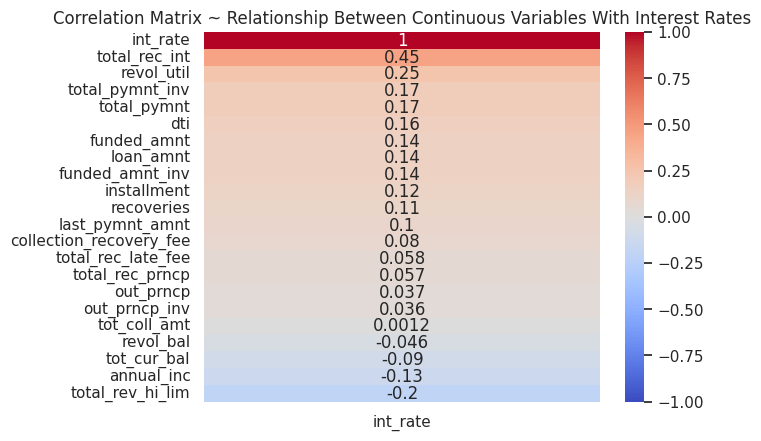

<Figure size 640x480 with 0 Axes>

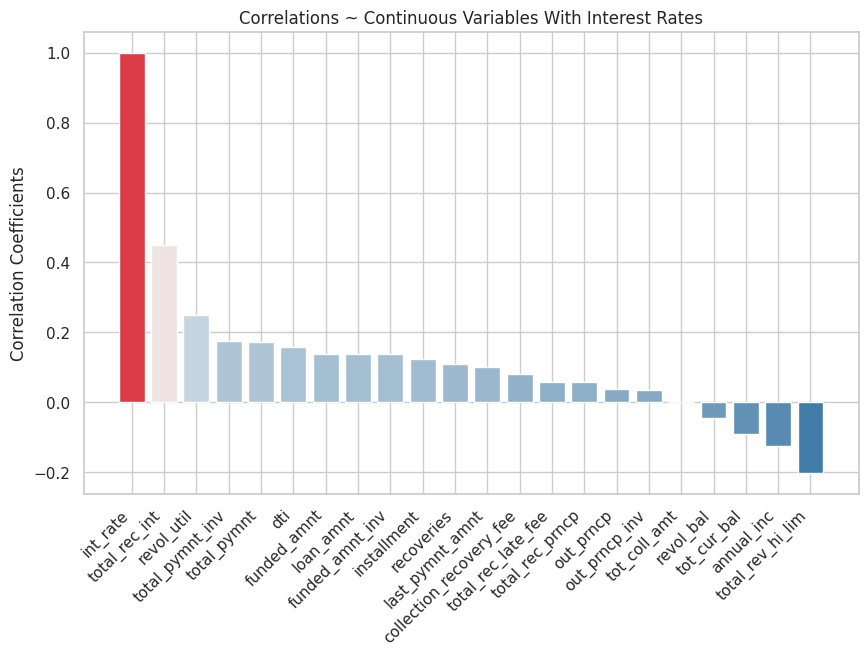

<Figure size 640x480 with 0 Axes>

In [38]:
# Step 1 : Determine the correlation matrix
correlation_matrix_cont = interest_rate_df_eda[continuous_vars].corr()
display(correlation_matrix_cont)

# Step 2 : Seperate the correlations of continuous variables with interest rates
correlations_with_interest_rates = correlation_matrix_cont['int_rate'].sort_values(ascending = False)
display(correlations_with_interest_rates)

# Step 3 : Visualise the correlations through a heatmap and barplot
# Heatmap
sns.heatmap(correlations_with_interest_rates.to_frame(),annot = True,cmap = 'coolwarm',vmin = -1,vmax = 1)
plt.title('Correlation Matrix ~ Relationship Between Continuous Variables With Interest Rates')
plt.show()
plt.clf()

# Barplot (Alternative Visualisation)
cmap = sns.diverging_palette(240,10,n = 256,as_cmap = True)
norm = plt.Normalize(correlations_with_interest_rates.min(),correlations_with_interest_rates.max())
plt.figure(figsize = (10,6))
bars = plt.bar(correlations_with_interest_rates.index,correlations_with_interest_rates.values,color = cmap(norm(correlations_with_interest_rates.values)))
plt.title('Correlations ~ Continuous Variables With Interest Rates')
plt.ylabel('Correlation Coefficients')
plt.xticks(rotation = 45,ha = 'right')
plt.show()
plt.clf()

# Direct Relationship - Positive Values
# Inverse Relationship - Negative Values
# No Relationship - Zero or Close to Zero

In [70]:
print(len(discrete_vars)) # 8 discrete variables
print(discrete_vars)

8
Index(['emp_length', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq'],
      dtype='object')


##### B : Discrete Variables

##### B1 : Employment Length (Spearman Rank Correlation and Boxplot Representation)

int_rate  emp_length
int_rate     1.00000     0.00319
emp_length   0.00319     1.00000

<ipython-input-40-fe3c98a9a1a3>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = interest_rate_df_eda['emp_length'],y = interest_rate_df_eda['int_rate'],palette = 'coolwarm')


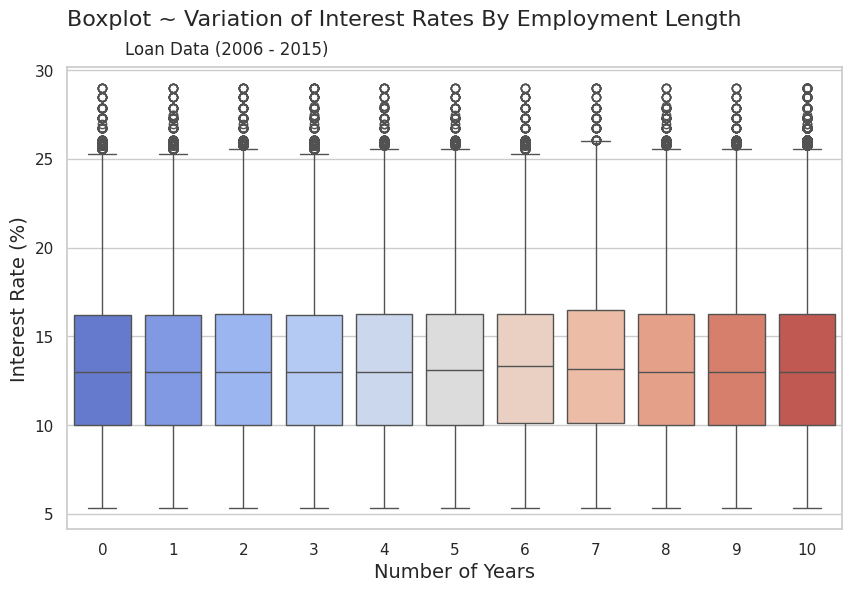

In [40]:
# Employment length is an ordinal variable, therefore for understanding the existence of a monotonic relationship
# between interest rates and employment length, the Spearman's Rank Correlation can be used which handles non-linear relationships.

# Spearman Rank Correlation between Interest Rates and Employment Length
int_rate_emp_length_corr = interest_rate_df_eda[['int_rate','emp_length']].corr(method = 'spearman') # Handles non-linear relationships.
display(int_rate_emp_length_corr) # Correlation is almost zero (0.00319)

# Boxplot of Interest Rates and Employment Length
sns.set(style = "whitegrid")
plt.figure(figsize = (10,6))
sns.boxplot(x = interest_rate_df_eda['emp_length'],y = interest_rate_df_eda['int_rate'],palette = 'coolwarm')
plt.title('Boxplot ~ Variation of Interest Rates By Employment Length',fontsize = 16,loc = 'left',pad = 30)
plt.text(0,1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
plt.xlabel('Number of Years',fontsize = 14)
plt.ylabel('Interest Rate (%)',fontsize = 14)
plt.show() # The similarity in distribution of interest rates across different employment lengths signfies the estimated correlation.

##### B2 : Delinquencies, Inquires, Public Derogatory Records and Collections (Boxplots)

<ipython-input-41-3dfade55260b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x = interest_rate_df_eda[i],y = interest_rate_df_eda['int_rate'],palette = 'coolwarm')


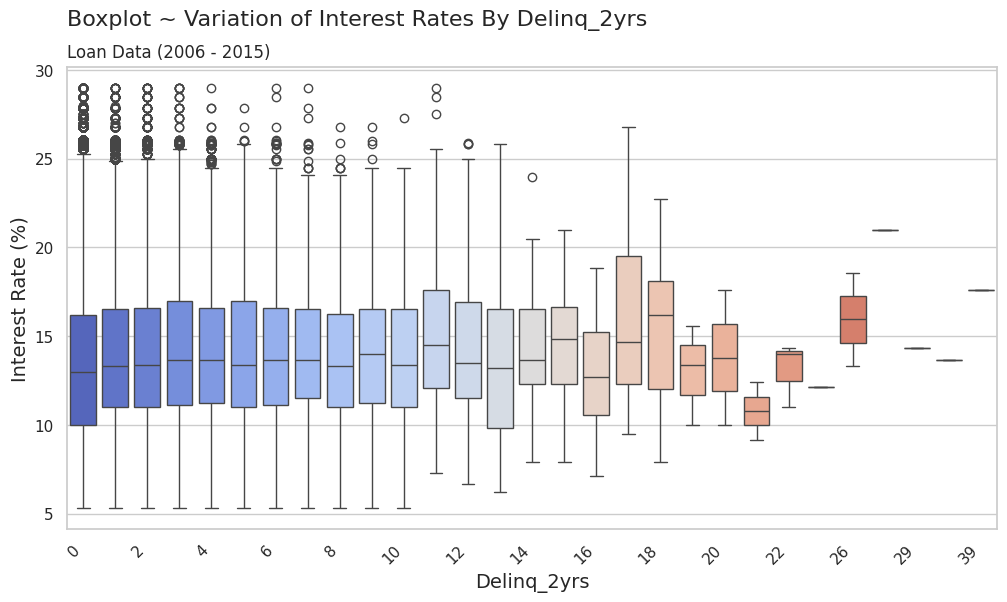

<ipython-input-41-3dfade55260b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x = interest_rate_df_eda[i],y = interest_rate_df_eda['int_rate'],palette = 'coolwarm')


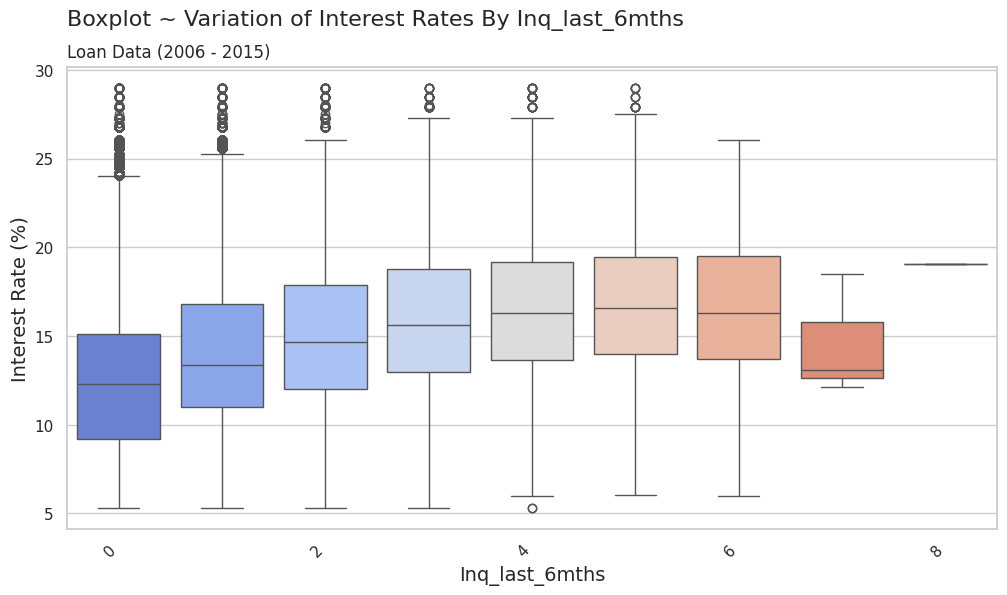

<ipython-input-41-3dfade55260b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x = interest_rate_df_eda[i],y = interest_rate_df_eda['int_rate'],palette = 'coolwarm')


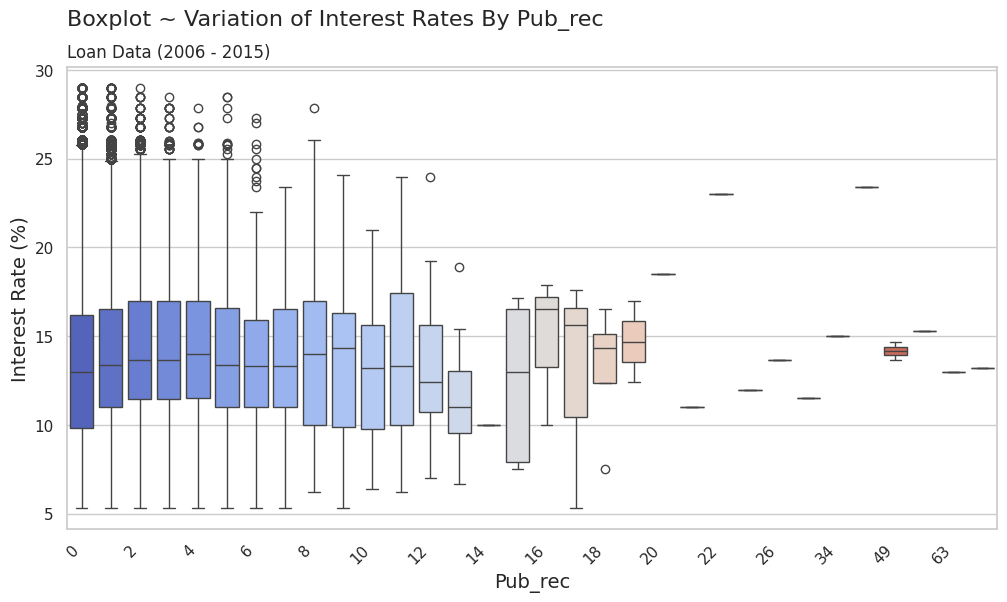

<ipython-input-41-3dfade55260b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x = interest_rate_df_eda[i],y = interest_rate_df_eda['int_rate'],palette = 'coolwarm')


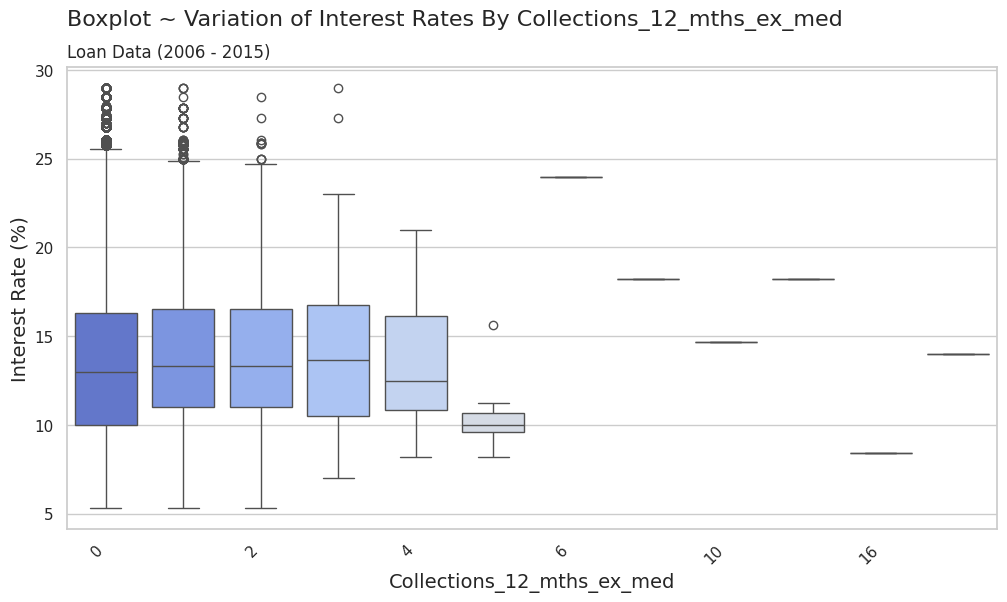

<ipython-input-41-3dfade55260b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x = interest_rate_df_eda[i],y = interest_rate_df_eda['int_rate'],palette = 'coolwarm')


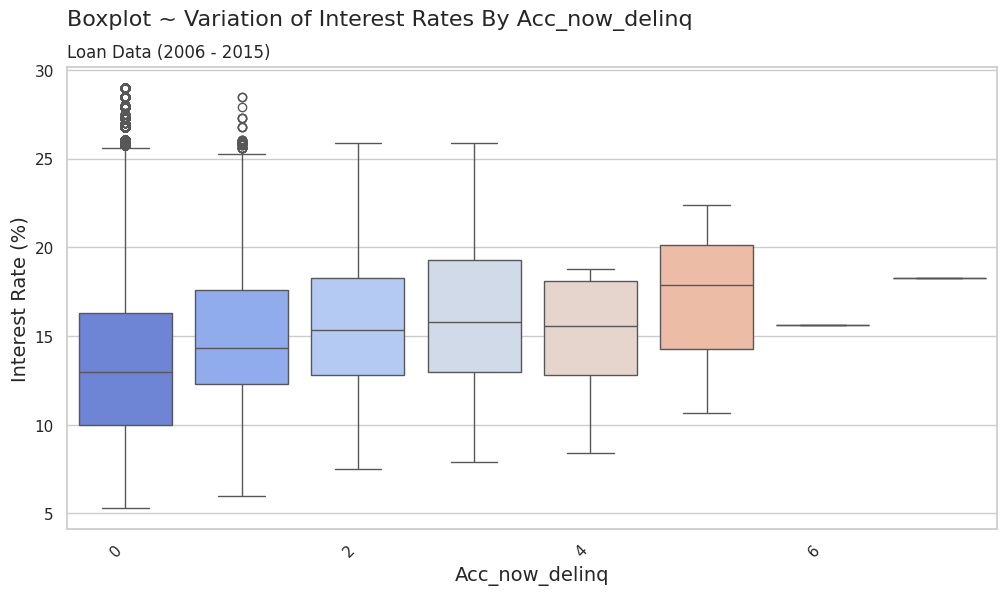

In [41]:
# Visualise the distribution of interest rates with borrower defaults, credit inquiries, collections and number of delinquent accounts
dv_credit_risk_indicators = ['delinq_2yrs','inq_last_6mths','pub_rec',
                                  'collections_12_mths_ex_med','acc_now_delinq']

sns.set(style = "whitegrid")
for i in dv_credit_risk_indicators:
    plt.figure(figsize = (12,6))
    ax = sns.boxplot(x = interest_rate_df_eda[i],y = interest_rate_df_eda['int_rate'],palette = 'coolwarm')
    plt.title(f'Boxplot ~ Variation of Interest Rates By {i.capitalize()}',fontsize = 16,loc = 'left',pad = 30)
    plt.text(0,1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
    plt.xlabel(i.capitalize(),fontsize = 14)
    plt.xticks(rotation = 45,ha = 'right')
    ax.set_xticks(ax.get_xticks()[::2]) # This displays every second label.
    plt.ylabel('Interest Rate (%)',fontsize = 14)
    plt.show() # The non-overlapping boxplots suggest that there might be variation in interest rates across the groups for
               # each discrete variable.

In [42]:
# Examine if there is a significant difference in interest rates across groups of the defined discrete variables.
# Define the Levene's test for inspecting if the ratios of variances in interest rates across groups of each discrete variable
# is equal to 1. If the p-value is less than 0.05 (the principle of homogeneity of variances is violated), the Kruskal-Wallis
# test can be used for inspecting the signficance of interest rates and discrete variables.

# Levene's Test for Homogeneity of Variances
for i in dv_credit_risk_indicators:
    stat,p_value = levene(*[interest_rate_df_eda['int_rate'][interest_rate_df_eda[i] == level]
                            for level in interest_rate_df_eda[i].unique()])
    print(f"Levene's Test for {i} -> Statistic: {stat:.5f},p-value: {p_value:.5f}")

# Kruskal-Wallis (Signficance Test)
for i in dv_credit_risk_indicators:
    stat,p_value = kruskal(*[interest_rate_df_eda['int_rate'][interest_rate_df_eda[i] == level]
                              for level in interest_rate_df_eda[i].unique()])
    print(f"Kruskal-Wallis Test for {i} -> Statistic: {stat:.5f},p-value: {p_value:.5f}") # The defined variables are signficant.

Levene's Test for delinq_2yrs -> Statistic: 19.69510,p-value: 0.00000
Levene's Test for inq_last_6mths -> Statistic: 63.97585,p-value: 0.00000
Levene's Test for pub_rec -> Statistic: 48.57486,p-value: 0.00000
Levene's Test for collections_12_mths_ex_med -> Statistic: 8.33727,p-value: 0.00000
Levene's Test for acc_now_delinq -> Statistic: 7.07418,p-value: 0.00000
Kruskal-Wallis Test for delinq_2yrs -> Statistic: 2464.28040,p-value: 0.00000
Kruskal-Wallis Test for inq_last_6mths -> Statistic: 44391.06789,p-value: 0.00000
Kruskal-Wallis Test for pub_rec -> Statistic: 3212.93543,p-value: 0.00000
Kruskal-Wallis Test for collections_12_mths_ex_med -> Statistic: 152.77294,p-value: 0.00000
Kruskal-Wallis Test for acc_now_delinq -> Statistic: 588.44314,p-value: 0.00000


##### B2 : Open and Total Accounts (Borrower)

<ipython-input-43-e8dd0af09535>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x = interest_rate_df_eda[i],y = interest_rate_df_eda['int_rate'],palette = 'coolwarm')


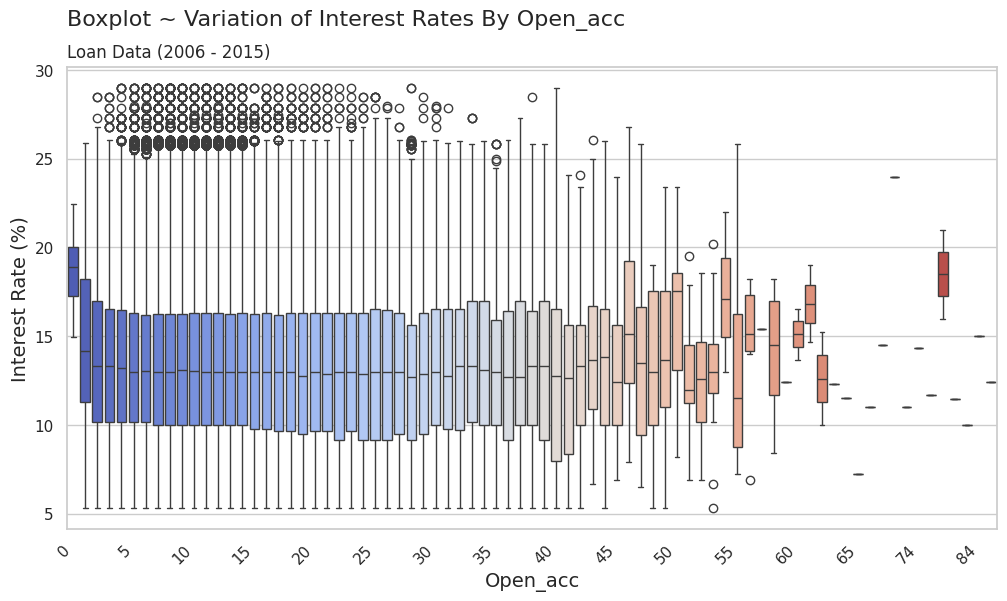

<ipython-input-43-e8dd0af09535>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x = interest_rate_df_eda[i],y = interest_rate_df_eda['int_rate'],palette = 'coolwarm')


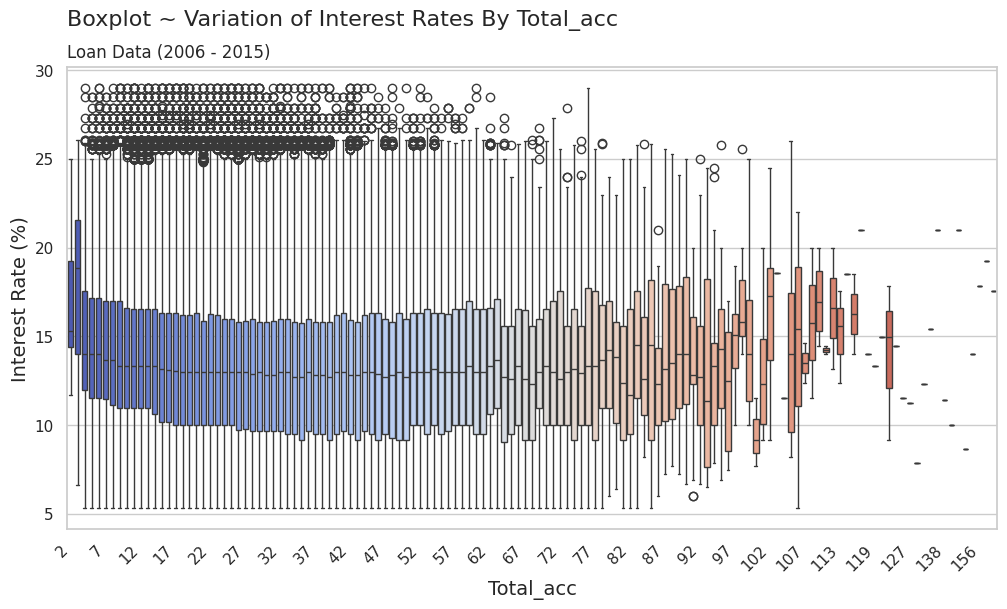

In [43]:
# Visualise the distribution of interest rates across borrower accounts related discrete variables
dv_borrower_accounts = ['open_acc','total_acc']

sns.set(style = "whitegrid")
for i in dv_borrower_accounts:
    plt.figure(figsize = (12,6))
    ax = sns.boxplot(x = interest_rate_df_eda[i],y = interest_rate_df_eda['int_rate'],palette = 'coolwarm')
    plt.title(f'Boxplot ~ Variation of Interest Rates By {i.capitalize()}',fontsize = 16,loc = 'left',pad = 30)
    plt.text(0,1.02,"Loan Data (2006 - 2015)",fontsize = 12,ha = 'left',transform = ax.transAxes)
    plt.xlabel(i.capitalize(),fontsize = 14)
    plt.xticks(rotation = 45,ha = 'right')
    ax.set_xticks(ax.get_xticks()[::5]) # This shows every fifth label.
    plt.ylabel('Interest Rate (%)',fontsize = 14)
    plt.show()

In [44]:
# Similarly, Levene's Test for Homogenity of Variances will be done, followed by Kruskal-Wallis Test for signficance
# with interest rates.

# Levene's Test for Homogeneity of Variances
for i in dv_borrower_accounts:
    stat,p_value = levene(*[interest_rate_df_eda['int_rate'][interest_rate_df_eda[i] == level]
                            for level in interest_rate_df_eda[i].unique()])
    print(f"Levene's Test for {i} -> Statistic: {stat:.5f},p-value: {p_value:.5f}")

# Kruskal-Wallis (Signficance Test)
for i in dv_borrower_accounts:
    stat,p_value = kruskal(*[interest_rate_df_eda['int_rate'][interest_rate_df_eda[i] == level]
                              for level in interest_rate_df_eda[i].unique()])
    print(f"Kruskal-Wallis Test for {i} -> Statistic: {stat:.5f},p-value: {p_value:.5f}") # The defined variables are significant.

Levene's Test for open_acc -> Statistic: 11.13405,p-value: 0.00000
Levene's Test for total_acc -> Statistic: 6.43875,p-value: 0.00000
Kruskal-Wallis Test for open_acc -> Statistic: 495.24343,p-value: 0.00000
Kruskal-Wallis Test for total_acc -> Statistic: 3646.60760,p-value: 0.00000


##### 1.1.7 Address Multi-Collinearity of Independent Variables

##### A : Continuous Variables

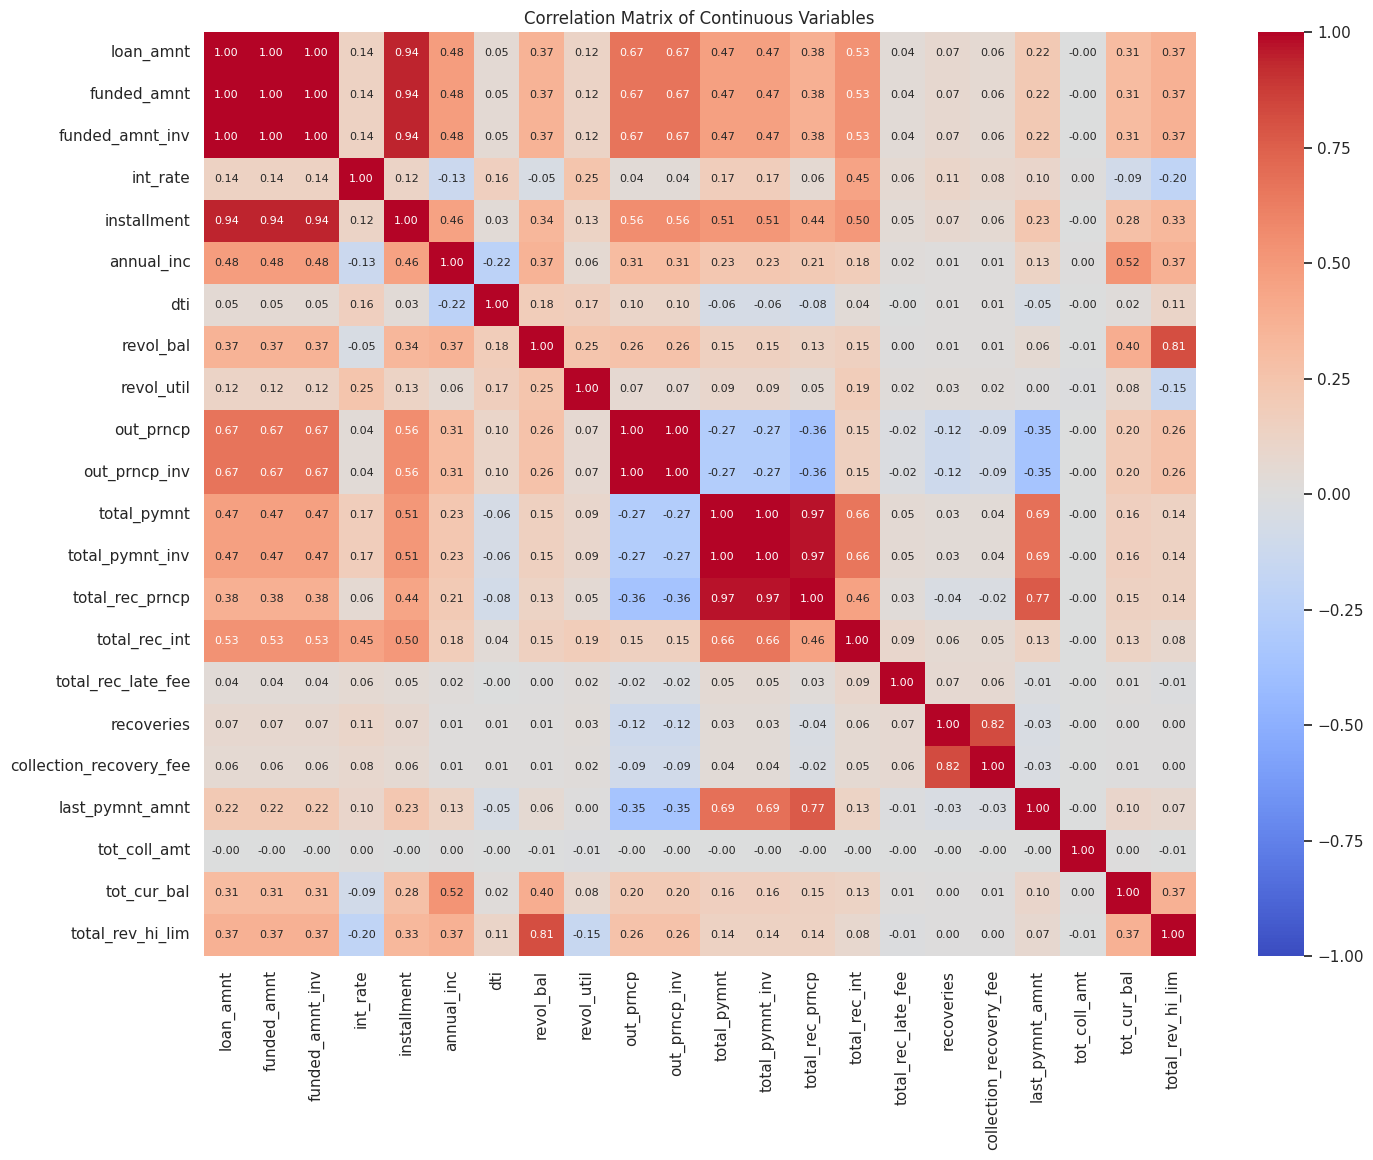

In [45]:
# print(continuous_vars)
# print(discrete_vars)

# Display the correlation matrix for continuous variables
plt.figure(figsize = (16, 12))
sns.heatmap(interest_rate_df_eda[continuous_vars].corr(),annot = True,fmt = ".2f",annot_kws = {'size': 8},cmap = 'coolwarm',vmin = -1,vmax = 1,cbar = True)
plt.title('Correlation Matrix of Continuous Variables')
plt.show()

In [46]:
# Inspect the continuous variables with high correlations
correlation_threshold = 0.8 # Set a threshold of 0.8 to detect variable that have high correlations.
correlation_matrix_cont_1 = interest_rate_df_eda[continuous_vars].corr() # Correlation matrix for continuous variables.
high_correlations_cont_1 = correlation_matrix_cont_1[correlation_matrix_cont_1.abs() > correlation_threshold] # High correlations for continuous variables.
high_correlations_cont_1 = high_correlations_cont_1[high_correlations_cont_1 != 1.0] # Remove self-correlations from the data frame.
high_correlations_cont_1_filtered = high_correlations_cont_1.where(np.triu(np.ones(high_correlations_cont_1.shape),k = 1).astype(np.bool_)) # Avoid correlation pairs
                                                                                                                                            # with the same variable.
high_correlations_cont_1_filtered = high_correlations_cont_1.unstack().dropna().sort_values(ascending = False).drop_duplicates() # Sort and remove duplicates.
display(high_correlations_cont_1_filtered) # Display the high correlations filtered data frame.

# Variance Inflation Factor (VIF)
# Add a constant which represents the intercept for regression models.
multi_collinearity_cont_1 = add_constant(interest_rate_df_eda[continuous_vars])
vif_check = pd.DataFrame() # Create a data frame to store the VIF values.
vif_check['Features'] = multi_collinearity_cont_1.columns # Add the continuous variables to the data frame.
vif_check['VIF'] = [round(variance_inflation_factor(multi_collinearity_cont_1.values,i),3) for i in range(multi_collinearity_cont_1.shape[1])] # Calculate the VIF values.
display(vif_check)

loan_amnt                funded_amnt         1.000000
out_prncp                out_prncp_inv       0.999997
total_pymnt_inv          total_pymnt         0.999997
funded_amnt_inv          funded_amnt         0.999995
loan_amnt                funded_amnt_inv     0.999994
total_pymnt              total_rec_prncp     0.969267
total_pymnt_inv          total_rec_prncp     0.969256
installment              funded_amnt         0.943201
loan_amnt                installment         0.943200
funded_amnt_inv          installment         0.943186
collection_recovery_fee  recoveries          0.824103
revol_bal                total_rev_hi_lim    0.814728
dtype: float64

Features           VIF
0                     const  3.549200e+01
1                 loan_amnt  3.033414e+06
2               funded_amnt  7.422932e+06
3           funded_amnt_inv  4.398239e+06
4                  int_rate  1.753000e+00
5               installment  1.132700e+01
6                annual_inc  1.902000e+00
7                       dti  1.225000e+00
8                 revol_bal  5.285000e+00
9                revol_util  1.866000e+00
10                out_prncp  4.232574e+06
11            out_prncp_inv  4.232240e+06
12              total_pymnt  8.417943e+13
13          total_pymnt_inv  2.818682e+06
14          total_rec_prncp  6.085945e+13
15            total_rec_int  5.976907e+12
16       total_rec_late_fee  1.980837e+07
17               recoveries  2.091245e+11
18  collection_recovery_fee  3.144000e+00
19          last_pymnt_amnt  3.753000e+00
20             tot_coll_amt  1.000000e+00
21              tot_cur_bal  1.508000e+00
22         total_rev_hi_lim  5.389000e+00

##### B : Discrete Variables

In [47]:
print(discrete_vars) # Inspect the discrete variables.
for i in discrete_vars:
  print(i,interest_rate_df_eda[i].unique()) # Inspect the unique values for each discrete variable.

Index(['emp_length', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq'],
      dtype='object')
emp_length [10  1  2  4  3  7  6  9  5  0  8]
delinq_2yrs [ 0  1  2  6  4  3  5  7  8  9 15 11 13 10 12 17 18 29 24 14 21 22 19 16
 30 26 20 27 39]
inq_last_6mths [0 1 2 4 3 5 6 7 8]
open_acc [14 12  7  8  9  6  4  5 17 10 16 15  3 29 13 11 20 19 21 27 18 25 30 22
 23 24 40 26  2 28 31  1 37 32 33 42 41 34 39 36 35 45 49 38 53 51 43  0
 62 46 48 50 52 44 54 47 76 58 55 84 75 61 65 67 57 66 68 70 60 56 82 63
 64 79 59 74 90]
pub_rec [ 0  2  1  3  4  5  6  9  7  8 11 49 10 54 12 18 19 15 40 63 13 34 17 23
 26 28 20 86 21 14 16 22]
total_acc [ 27  28  22  32  29  19  14   5  26  30  24  12  39  16  17  18   8  41
  36  10  49  35  43  13  20  44  37  33  23  31  25  56  52  38  21  48
  60  34  40   9  53  45  11  15  50  63  51  46  54   7  42   4  47  59
   6  58  57  61  55  65  62   3 105  83  64  71   2  66  68  69  67

In [48]:
# For detecting multi-collinearity in discrete variables we can use an integration of
# of two methods Cramer's V Statistic and Chi-Squared Test of Independence.

# Cramer's V Statistic : Strength and direction of association between two nominal categorical variables.
# Chi-Squared Test of Independence : Tests whether two categorical variables are independent.

# Define Cramer's V Statistic for discrete variables
def cramers_v(x,y):
    table = pd.crosstab(x,y)
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    phi2 = chi2 / n
    r,k = table.shape
    phi2_corr = max(0,phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1),(r_corr-1)))

# Define a list that consists of all pairs of combinations
discrete_vars_pairs = list(itertools.combinations(interest_rate_df_eda[discrete_vars],2))

# Define an empty list for storing the results
results = []
for var1,var2 in discrete_vars_pairs:
    cramer_v_value = cramers_v(interest_rate_df_eda[var1],interest_rate_df_eda[var2])
    table = pd.crosstab(interest_rate_df_eda[var1],interest_rate_df_eda[var2])
    chi2,p,_,_ = chi2_contingency(table)
    results.append({
        'var1': var1,
        'var2': var2,
        'chi2_statistic': chi2,
        'p_value': p,
        'cramers_v': cramer_v_value,
        'dependent': 'Yes' if p < 0.05 else 'No'
    })

# Display the results in a data frame
discrete_associations_df = pd.DataFrame(results)
# display(discrete_associations_df)

# Function for classifying the strength of association between the pairs of discrete variables
# with cramers_statistic as the parameter
def association_strength(cramers_statistic):
    if cramers_statistic <= 0.1: # A cramers_v value of less than or equal to 0.1 is relative to a low association between the
                                 # discrete variables.
        return 'Low Association'
    elif cramers_statistic <= 0.3: # A cramers_v value of less than or equal to 0.3 is relative to a moderate association between the
                                   # discrete variables.
        return 'Moderate Association'
    else:
        return 'High Association' # A cramers_v value of greater than 0.3 is relative to a high association.

# Define a new variable to the data frame for association strength
discrete_associations_df['association_strength'] = discrete_associations_df['cramers_v'].apply(association_strength)
display(discrete_associations_df)

# Filter the data frame for high associations
discrete_high_assocations_df = discrete_associations_df[(discrete_associations_df['p_value'] < 0.05) & (discrete_associations_df['cramers_v'] > 0.3)]
display(discrete_high_assocations_df)

var1                        var2  chi2_statistic  \
0                   emp_length                 delinq_2yrs    2.050897e+03   
1                   emp_length              inq_last_6mths    1.645549e+02   
2                   emp_length                    open_acc    2.898506e+03   
3                   emp_length                     pub_rec    1.317710e+03   
4                   emp_length                   total_acc    1.497868e+04   
5                   emp_length  collections_12_mths_ex_med    1.599047e+02   
6                   emp_length              acc_now_delinq    1.726305e+02   
7                  delinq_2yrs              inq_last_6mths    8.749698e+02   
8                  delinq_2yrs                    open_acc    6.535750e+03   
9                  delinq_2yrs                     pub_rec    1.786872e+03   
10                 delinq_2yrs                   total_acc    7.153681e+04   
11                 delinq_2yrs  collections_12_mths_ex_med    3.081227e+04   
12                 delinq_2yrs              acc_now_delinq    4.791062e+04   
13              inq_last_6mths                    open_acc    1.461491e+04   
14              inq_last_6mths                     pub_rec    5.611369e+03   
15              inq_last_6mths                   total_acc    1.811029e+04   
16              inq_last_6mths  collections_12_mths_ex_med    2.304867e+02   
17              inq_last_6mths              acc_now_delinq    1.934168e+02   
18                    open_acc                     pub_rec    9.976032e+03   
19                    open_acc                   total_acc    5.847213e+06   
20                    open_acc  collections_12_mths_ex_med    4.720739e+02   
21                    open_acc              acc_now_delinq    2.253996e+03   
22                     pub_rec                   total_acc    4.662432e+03   
23                     pub_rec  collections_12_mths_ex_med    4.856331e+02   
24                     pub_rec              acc_now_delinq    5.507332e+01   
25                   total_acc  collections_12_mths_ex_med    1.403044e+03   
26                   total_acc              acc_now_delinq    1.690982e+03   
27  collections_12_mths_ex_med              acc_now_delinq    7.579896e+05   

          p_value  cramers_v dependent association_strength  
0   1.780995e-266   0.015290       Yes      Low Association  
1    8.403501e-08   0.003735       Yes      Low Association  
2   2.555702e-246   0.016802       Yes      Low Association  
3   3.818778e-124   0.011534       Yes      Low Association  
4    0.000000e+00   0.042464       Yes      Low Association  
5    1.340281e-03   0.002567       Yes      Low Association  
6    1.210521e-10   0.004399       Yes      Low Association  
7    1.071619e-77   0.010364       Yes      Low Association  
8    0.000000e+00   0.014416       Yes      Low Association  
9    6.546126e-66   0.006582       Yes      Low Association  
10   0.000000e+00   0.056557       Yes      Low Association  
11   0.000000e+00   0.060506       Yes      Low Association  
12   0.000000e+00   0.094861       Yes      Low Association  
13   0.000000e+00   0.048077       Yes      Low Association  
14   0.000000e+00   0.029750       Yes      Low Association  
15   0.000000e+00   0.053050       Yes      Low Association  
16   1.042773e-14   0.004849       Yes      Low Association  
17   5.134330e-17   0.005091       Yes      Low Association  
18   0.000000e+00   0.018014       Yes      Low Association  
19   0.000000e+00   0.318440       Yes     High Association  
20   1.000000e+00   0.000000        No      Low Association  
21  5.544623e-210   0.018021       Yes      Low Association  
22   7.632267e-10   0.004929       Yes      Low Association  
23   4.103473e-07   0.004166       Yes      Low Association  
24   1.000000e+00   0.000000        No      Low Association  
25   8.176583e-01   0.000000        No      Low Association  
26   1.144577e-47   0.012027       Yes      Low Association  
27   0.000000e+00   0.37807

var1            var2  chi2_statistic  p_value  \
19                    open_acc       total_acc    5.847213e+06      0.0   
27  collections_12_mths_ex_med  acc_now_delinq    7.579896e+05      0.0   

    cramers_v dependent association_strength  
19   0.318440       Yes     High Association  
27   0.378071       Yes     High Association

##### 1.1.8 Linear Relationships between Signficant Variables (Continuous) with Interest Rates

##### A : Direct Relationships with Interest Rates

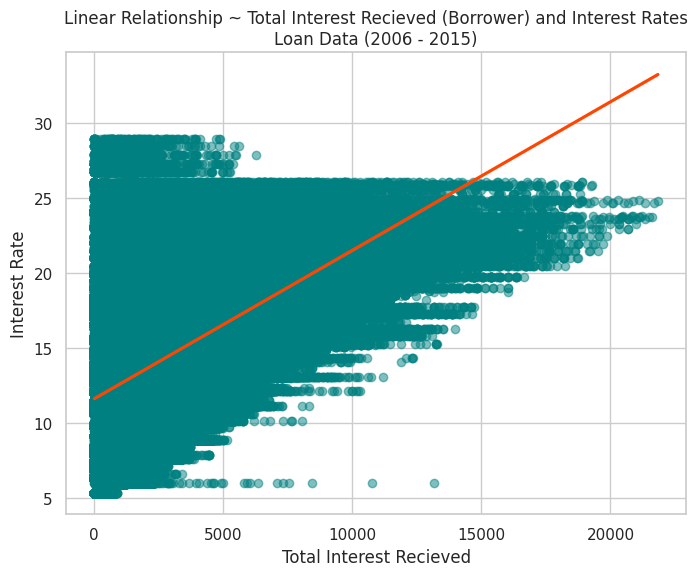

<Figure size 640x480 with 0 Axes>

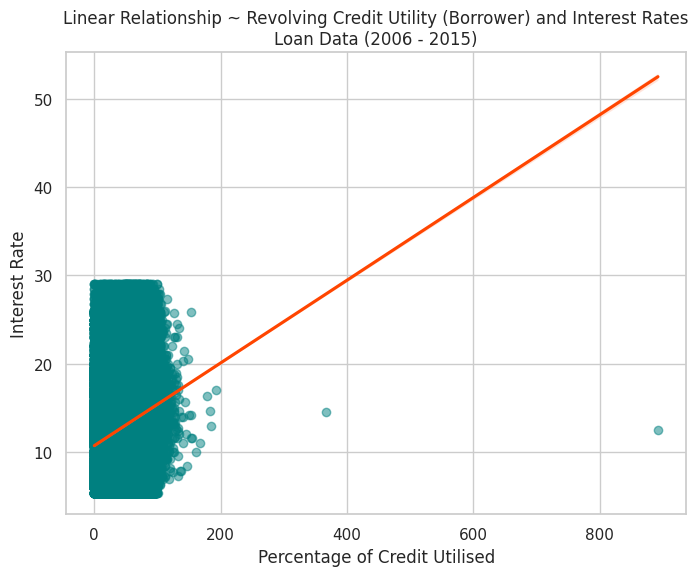

<Figure size 640x480 with 0 Axes>

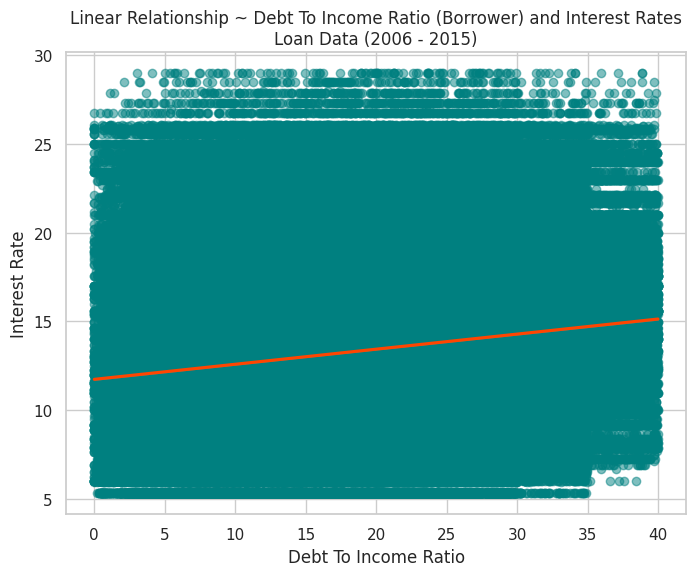

<Figure size 640x480 with 0 Axes>

In [49]:
# All the discrete variables are significant.
signficant_positive_correlations = ['total_rec_int','revol_util','dti']

scatter_color = '#008080'
line_color = '#FF4500'

# total_rec_int
plt.figure(figsize = (8,6))
sns.regplot(x = interest_rate_df_eda['total_rec_int'],y=interest_rate_df_eda['int_rate'],scatter_kws = {'color':scatter_color,'alpha': 0.5},
            line_kws = {"color": line_color})
plt.title('Linear Relationship ~ Total Interest Recieved (Borrower) and Interest Rates\nLoan Data (2006 - 2015)')
plt.xlabel('Total Interest Recieved')
plt.ylabel('Interest Rate')
plt.show()
plt.clf()

# revol_util
plt.figure(figsize = (8,6))
sns.regplot(x = interest_rate_df_eda['revol_util'],y=interest_rate_df_eda['int_rate'],scatter_kws = {'color':scatter_color,'alpha': 0.5},
            line_kws = {"color": line_color})
plt.title('Linear Relationship ~ Revolving Credit Utility (Borrower) and Interest Rates\nLoan Data (2006 - 2015)')
plt.xlabel('Percentage of Credit Utilised')
plt.ylabel('Interest Rate')
plt.show()
plt.clf()

# dti
plt.figure(figsize = (8,6))
sns.regplot(x = interest_rate_df_eda['dti'],y=interest_rate_df_eda['int_rate'],scatter_kws = {'color':scatter_color,'alpha': 0.5},
            line_kws = {"color": line_color})
plt.title('Linear Relationship ~ Debt To Income Ratio (Borrower) and Interest Rates\nLoan Data (2006 - 2015)')
plt.xlabel('Debt To Income Ratio')
plt.ylabel('Interest Rate')
plt.show()
plt.clf()

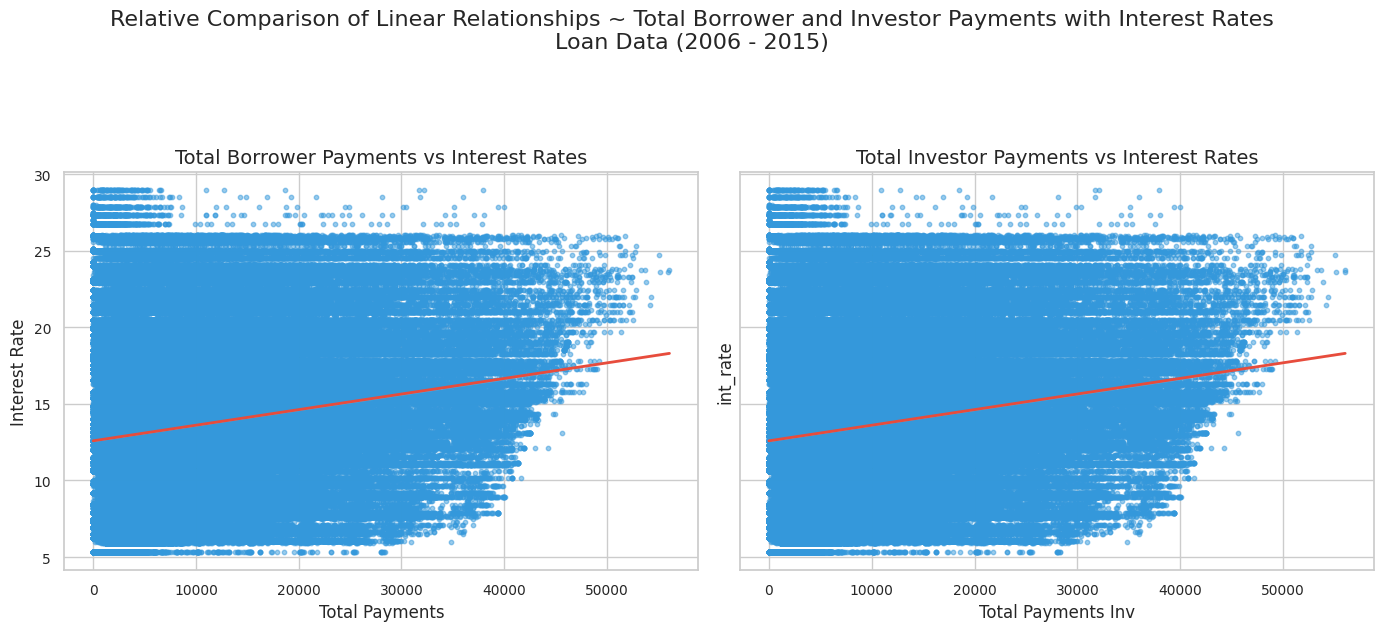

In [50]:
# Relative Comparison of Total Payments (By Borrower) and Total Payment (To Investor)
fig,axs = plt.subplots(1,2,figsize = (14,6),sharey = True)
scatter_color = '#3498db'
line_color = '#e74c3c'

# Font Size (Adjustments)
title_fontsize = 14
label_fontsize = 12
tick_fontsize = 10

# First Plot : Total Payments (Borrower) vs Interest Rates
sns.regplot(x = interest_rate_df_eda['total_pymnt'],y = interest_rate_df_eda['int_rate'],
            scatter_kws = {'color': scatter_color,'alpha': 0.5,'s': 10},
            line_kws = {"color": line_color,'lw': 2},ax = axs[0])
axs[0].set_title('Total Borrower Payments vs Interest Rates',fontsize = title_fontsize)
axs[0].set_xlabel('Total Payments',fontsize = label_fontsize)
axs[0].set_ylabel('Interest Rate',fontsize = label_fontsize)
axs[0].tick_params(axis = 'both',which = 'major',labelsize = tick_fontsize)

# Second Plot : Total Payments (Investor) vs Interest Rates
sns.regplot(x = interest_rate_df_eda['total_pymnt_inv'],y = interest_rate_df_eda['int_rate'],
            scatter_kws = {'color': scatter_color,'alpha': 0.5,'s': 10},
            line_kws = {"color": line_color,'lw': 2},ax = axs[1])
axs[1].set_title('Total Investor Payments vs Interest Rates',fontsize = title_fontsize)
axs[1].set_xlabel('Total Payments Inv',fontsize = label_fontsize)
axs[1].tick_params(axis = 'both',which = 'major',labelsize = tick_fontsize)

# Title and Layout (Adjustments)
fig.suptitle('Relative Comparison of Linear Relationships ~ Total Borrower and Investor Payments with Interest Rates\nLoan Data (2006 - 2015)',
             fontsize = 16,y = 1.05)
plt.tight_layout(rect = [0,0,1,0.95])
plt.show()

##### B : Inverse Relationships with Interest Rates

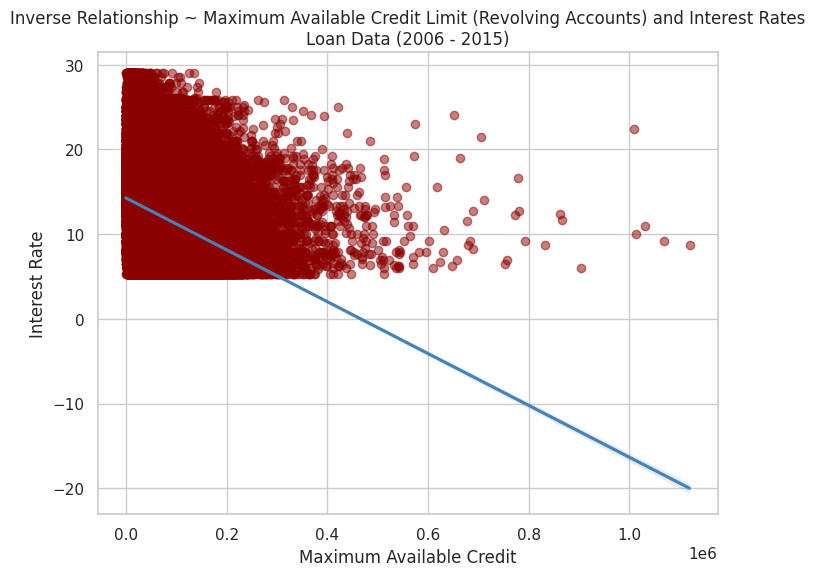

<Figure size 640x480 with 0 Axes>

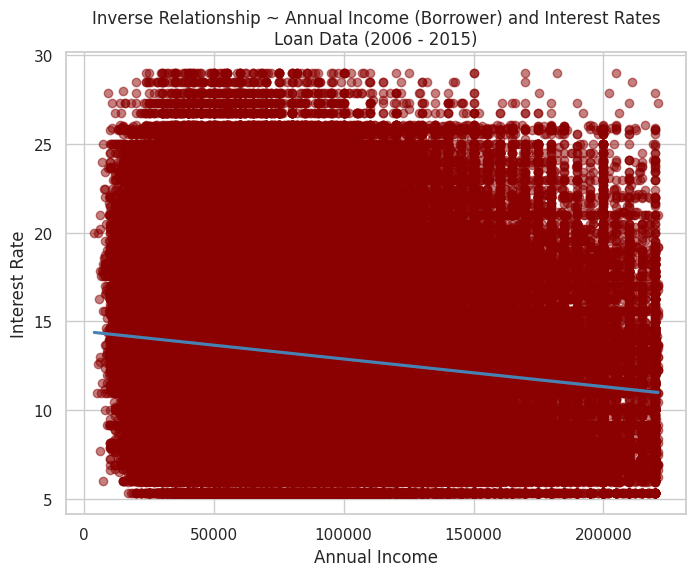

<Figure size 640x480 with 0 Axes>

In [51]:
signficant_negative_correlations = ['total_rev_hi_lim','annual_inc']

scatter_color = '#8B0000'
line_color = '#4682B4'

# total_rev_hi_lim
plt.figure(figsize = (8,6))
sns.regplot(x = interest_rate_df_eda['total_rev_hi_lim'],y = interest_rate_df_eda['int_rate'],
            scatter_kws = {'color': scatter_color,'alpha': 0.5},
            line_kws = {"color": line_color})
plt.title('Inverse Relationship ~ Maximum Available Credit Limit (Revolving Accounts) and Interest Rates\nLoan Data (2006 - 2015)')
plt.xlabel('Maximum Available Credit')
plt.ylabel('Interest Rate')
plt.show()
plt.clf()

# annual_inc
plt.figure(figsize = (8, 6))
sns.regplot(x = interest_rate_df_eda['annual_inc'],y = interest_rate_df_eda['int_rate'],
            scatter_kws = {'color': scatter_color,'alpha': 0.5},
            line_kws = {"color": line_color})
plt.title('Inverse Relationship ~ Annual Income (Borrower) and Interest Rates\nLoan Data (2006 - 2015)')
plt.xlabel('Annual Income')
plt.ylabel('Interest Rate')
plt.show()
plt.clf()

##### 2.0 Identify Significant Categorical Relationships with Interest Rates

##### A : Variables (Included, Excluded and Require Transformation)

In [52]:
print(categorical_cols)
print(len(categorical_cols)) # 18 Categorical Variables.
print(interest_rate_df_eda[categorical_cols].nunique())
# Variables Exclude :
# emp_title : Employment title since it has extreme high cardinality with 257,001 unique values. The accuracy of the borrower
# information would be penalised if used for analysis since before 23 September 2013, the meta-data explains that prior to this
# date 'employer name' was used and post this date 'employer title' was recorded. This could affect the true representation of
# borrower information while finding explainability.
# title : This alos has high cardinality with 36,436 unqiue values and this represents the reason for loan application. This can
# be omitted from the analysis as a simpler and straightforward reasoning is given by the purpose variable. This also effectively
# decreases information redundancy and enhances the explainability during the model development phase.
# zip code : Considerably lower cardinality as compared to the employment title and title variable, however the inclusion of this
# within the analysis can present noise, complexity and in-accurate representation of variable information.

# Variable Transformations : issue_d, earliest_cr_line, last_pymnt_d, next_pymnt_d, last_credit_pull_d

# Pupose Variable : To be analysed towards the end of EDA process.

Index(['term', 'grade', 'sub_grade', 'emp_title', 'home_ownership',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line',
       'initial_list_status', 'last_pymnt_d', 'next_pymnt_d',
       'last_credit_pull_d'],
      dtype='object')
18
term                        2
grade                       7
sub_grade                  35
emp_title              257001
home_ownership              6
verification_status         3
issue_d                    41
loan_status                 8
pymnt_plan                  2
purpose                    14
title                   36436
zip_code                  930
addr_state                 51
earliest_cr_line          676
initial_list_status         2
last_pymnt_d               42
next_pymnt_d                4
last_credit_pull_d         43
dtype: int64


##### B : Levene's Test (Homogeneity of Variances)



In [53]:
# For identifying the signficant categorical variables with interest rates a 2 staged
# process can be deployed.
# Step 1:
# The Levene's test would be conducted for inspecting whether interest rates vary across groups
# within each categroical variable.
# Step 2:
# Then if the assumption of homogeneity of variances is true, the process of finding signficance
# can be further investigated through ANOVA, which inspects if the average of interest rates
# are signficant across each group of the categorical variable. For further inspecting which
# groups are signficant, the Tukey HSD test can be applied.
# However, if the homogeneity of variances is violated, the Kruskal-Wallis followed by
# the Dunns test can be applied.

categorical_variables_eda = ['term','grade','sub_grade','home_ownership','verification_status','loan_status',
                             'pymnt_plan','addr_state','initial_list_status']
print(len(categorical_variables_eda)) # 9

# Levene's Test (Homogeneity of Variances)
for i in categorical_variables_eda:
    stat,p_value = levene(*[interest_rate_df_eda['int_rate'][interest_rate_df_eda[i] == level]
                            for level in interest_rate_df_eda[i].unique()])
    print(f"Levene's Test for {i} -> Statistic: {stat:.5f},p-value: {p_value:.5f}")

# Variables that are signficant : All the variables have violated the assumption of homogeneity of variances except payment plan.
# Approach : Perform Kruskal-Wallis, followed by Dunns test for understanding which groups among categroies are signficant with
# interest rates.
# Payment Plan : Apply One-way ANOVA, followed by Tukey-HSD test for the same.

9
Levene's Test for term -> Statistic: 2221.83569,p-value: 0.00000
Levene's Test for grade -> Statistic: 4248.46408,p-value: 0.00000
Levene's Test for sub_grade -> Statistic: 1643.87492,p-value: 0.00000
Levene's Test for home_ownership -> Statistic: 78.93288,p-value: 0.00000
Levene's Test for verification_status -> Statistic: 1740.96254,p-value: 0.00000
Levene's Test for loan_status -> Statistic: 2.51762,p-value: 0.01379
Levene's Test for pymnt_plan -> Statistic: 0.66181,p-value: 0.41592
Levene's Test for addr_state -> Statistic: 4.68682,p-value: 0.00000
Levene's Test for initial_list_status -> Statistic: 208.75725,p-value: 0.00000


##### C : Kruskal-Wallis Test (Signficance of Interest Rate Variation among Categorical Variables)

In [54]:
# Kruskal-Wallis Test
signficant_categorical_vars_1 = ['term','grade','sub_grade','home_ownership','verification_status','loan_status',
                                  'addr_state','initial_list_status']
print(len(signficant_categorical_vars_1))

for var in signficant_categorical_vars_1:
    groups = [interest_rate_df_eda['int_rate'][interest_rate_df_eda[var] == level] for level in interest_rate_df_eda[var].unique()]
    stat,p = kruskal(*groups)
    print(f"Kruskal-Wallis Test for {var} -> Statistic: {stat:.5f},p-value: {p:.5f}")

8
Kruskal-Wallis Test for term -> Statistic: 134739.98687,p-value: 0.00000
Kruskal-Wallis Test for grade -> Statistic: 689182.94637,p-value: 0.00000
Kruskal-Wallis Test for sub_grade -> Statistic: 728139.03537,p-value: 0.00000
Kruskal-Wallis Test for home_ownership -> Statistic: 3540.27773,p-value: 0.00000
Kruskal-Wallis Test for verification_status -> Statistic: 49480.20538,p-value: 0.00000
Kruskal-Wallis Test for loan_status -> Statistic: 27849.92458,p-value: 0.00000
Kruskal-Wallis Test for addr_state -> Statistic: 1329.99521,p-value: 0.00000
Kruskal-Wallis Test for initial_list_status -> Statistic: 13886.04181,p-value: 0.00000


##### D : Dunns Test (Group Signficance among Categorical Variables)

In [55]:
# Dunns Test (Post-Hoc Analysis)
def dunn_test_interpretation(dunn_matrix,var):
    significant_pairs = []
    for i in dunn_matrix.index:
        for j in dunn_matrix.columns:
            if i != j and dunn_matrix.loc[i, j] < 0.05:
                significant_pairs.append(f"{i} vs {j} (p = {dunn_matrix.loc[i, j]:.5f})")
    if significant_pairs:
        print(f"Significant differences found in {var} between the following groups:")
        for pair in significant_pairs:
            print(f"  - {pair}")
    else:
        print(f"No significant differences found for {var}.")

# Examining which groups within each categorical variable are signficant with interest rates
for var in signficant_categorical_vars_1:
    dunn = sp.posthoc_dunn(interest_rate_df_eda,val_col = 'int_rate',group_col = var,p_adjust = 'bonferroni')
    display(f"\nDunn's Test for {var}:")
    dunn_test_interpretation(dunn,var) # Almost all of the groups within the categorical variables are signficant in the prediction
                                       # of interest rates.

"\nDunn's Test for term:"

Significant differences found in term between the following groups:
  - 36 months vs 60 months (p = 0.00000)
  - 60 months vs 36 months (p = 0.00000)


"\nDunn's Test for grade:"

Significant differences found in grade between the following groups:
  - A vs B (p = 0.00000)
  - A vs C (p = 0.00000)
  - A vs D (p = 0.00000)
  - A vs E (p = 0.00000)
  - A vs F (p = 0.00000)
  - A vs G (p = 0.00000)
  - B vs A (p = 0.00000)
  - B vs C (p = 0.00000)
  - B vs D (p = 0.00000)
  - B vs E (p = 0.00000)
  - B vs F (p = 0.00000)
  - B vs G (p = 0.00000)
  - C vs A (p = 0.00000)
  - C vs B (p = 0.00000)
  - C vs D (p = 0.00000)
  - C vs E (p = 0.00000)
  - C vs F (p = 0.00000)
  - C vs G (p = 0.00000)
  - D vs A (p = 0.00000)
  - D vs B (p = 0.00000)
  - D vs C (p = 0.00000)
  - D vs E (p = 0.00000)
  - D vs F (p = 0.00000)
  - D vs G (p = 0.00000)
  - E vs A (p = 0.00000)
  - E vs B (p = 0.00000)
  - E vs C (p = 0.00000)
  - E vs D (p = 0.00000)
  - E vs F (p = 0.00000)
  - E vs G (p = 0.00000)
  - F vs A (p = 0.00000)
  - F vs B (p = 0.00000)
  - F vs C (p = 0.00000)
  - F vs D (p = 0.00000)
  - F vs E (p = 0.00000)
  - F vs G (p = 0.01108)
  - G vs A (p = 0.00000)
  - G 

"\nDunn's Test for sub_grade:"

Significant differences found in sub_grade between the following groups:
  - A1 vs A2 (p = 0.00000)
  - A1 vs A3 (p = 0.00000)
  - A1 vs A4 (p = 0.00000)
  - A1 vs A5 (p = 0.00000)
  - A1 vs B1 (p = 0.00000)
  - A1 vs B2 (p = 0.00000)
  - A1 vs B3 (p = 0.00000)
  - A1 vs B4 (p = 0.00000)
  - A1 vs B5 (p = 0.00000)
  - A1 vs C1 (p = 0.00000)
  - A1 vs C2 (p = 0.00000)
  - A1 vs C3 (p = 0.00000)
  - A1 vs C4 (p = 0.00000)
  - A1 vs C5 (p = 0.00000)
  - A1 vs D1 (p = 0.00000)
  - A1 vs D2 (p = 0.00000)
  - A1 vs D3 (p = 0.00000)
  - A1 vs D4 (p = 0.00000)
  - A1 vs D5 (p = 0.00000)
  - A1 vs E1 (p = 0.00000)
  - A1 vs E2 (p = 0.00000)
  - A1 vs E3 (p = 0.00000)
  - A1 vs E4 (p = 0.00000)
  - A1 vs E5 (p = 0.00000)
  - A1 vs F1 (p = 0.00000)
  - A1 vs F2 (p = 0.00000)
  - A1 vs F3 (p = 0.00000)
  - A1 vs F4 (p = 0.00000)
  - A1 vs F5 (p = 0.00000)
  - A1 vs G1 (p = 0.00000)
  - A1 vs G2 (p = 0.00000)
  - A1 vs G3 (p = 0.00000)
  - A1 vs G4 (p = 0.00000)
  - A1 vs G5 (p = 0.00000)
  - A2 vs

"\nDunn's Test for home_ownership:"

Significant differences found in home_ownership between the following groups:
  - MORTGAGE vs NONE (p = 0.00886)
  - MORTGAGE vs OTHER (p = 0.00210)
  - MORTGAGE vs OWN (p = 0.00000)
  - MORTGAGE vs RENT (p = 0.00000)
  - NONE vs MORTGAGE (p = 0.00886)
  - NONE vs OWN (p = 0.04462)
  - OTHER vs MORTGAGE (p = 0.00210)
  - OTHER vs OWN (p = 0.01244)
  - OWN vs MORTGAGE (p = 0.00000)
  - OWN vs NONE (p = 0.04462)
  - OWN vs OTHER (p = 0.01244)
  - OWN vs RENT (p = 0.00000)
  - RENT vs MORTGAGE (p = 0.00000)
  - RENT vs OWN (p = 0.00000)


"\nDunn's Test for verification_status:"

Significant differences found in verification_status between the following groups:
  - Not Verified vs Source Verified (p = 0.00000)
  - Not Verified vs Verified (p = 0.00000)
  - Source Verified vs Not Verified (p = 0.00000)
  - Source Verified vs Verified (p = 0.00000)
  - Verified vs Not Verified (p = 0.00000)
  - Verified vs Source Verified (p = 0.00000)


"\nDunn's Test for loan_status:"

Significant differences found in loan_status between the following groups:
  - Charged Off vs Current (p = 0.00000)
  - Charged Off vs Fully Paid (p = 0.00000)
  - Charged Off vs In Grace Period (p = 0.00000)
  - Charged Off vs Issued (p = 0.00000)
  - Charged Off vs Late (16-30 days) (p = 0.00000)
  - Charged Off vs Late (31-120 days) (p = 0.00000)
  - Current vs Charged Off (p = 0.00000)
  - Current vs Default (p = 0.00000)
  - Current vs Fully Paid (p = 0.00000)
  - Current vs In Grace Period (p = 0.00000)
  - Current vs Issued (p = 0.00000)
  - Current vs Late (16-30 days) (p = 0.00000)
  - Current vs Late (31-120 days) (p = 0.00000)
  - Default vs Current (p = 0.00000)
  - Default vs Fully Paid (p = 0.00000)
  - Default vs In Grace Period (p = 0.00000)
  - Default vs Issued (p = 0.00000)
  - Fully Paid vs Charged Off (p = 0.00000)
  - Fully Paid vs Current (p = 0.00000)
  - Fully Paid vs Default (p = 0.00000)
  - Fully Paid vs In Grace Period (p = 0.00000)
  - Fully Paid vs Issued

"\nDunn's Test for addr_state:"

Significant differences found in addr_state between the following groups:
  - AK vs CO (p = 0.00577)
  - AK vs CT (p = 0.02030)
  - AK vs DC (p = 0.00000)
  - AK vs IL (p = 0.00601)
  - AK vs MA (p = 0.00000)
  - AK vs ME (p = 0.00001)
  - AK vs NH (p = 0.00002)
  - AK vs VT (p = 0.00494)
  - AK vs WI (p = 0.00015)
  - AL vs AR (p = 0.02969)
  - AL vs AZ (p = 0.00000)
  - AL vs CA (p = 0.00000)
  - AL vs CO (p = 0.00000)
  - AL vs CT (p = 0.00000)
  - AL vs DC (p = 0.00000)
  - AL vs FL (p = 0.00000)
  - AL vs GA (p = 0.00000)
  - AL vs IL (p = 0.00000)
  - AL vs IN (p = 0.00000)
  - AL vs KS (p = 0.00000)
  - AL vs KY (p = 0.00000)
  - AL vs LA (p = 0.00000)
  - AL vs MA (p = 0.00000)
  - AL vs MD (p = 0.00000)
  - AL vs ME (p = 0.00000)
  - AL vs MI (p = 0.00000)
  - AL vs MN (p = 0.00000)
  - AL vs MO (p = 0.00000)
  - AL vs MT (p = 0.00000)
  - AL vs NC (p = 0.00000)
  - AL vs ND (p = 0.00142)
  - AL vs NE (p = 0.00000)
  - AL vs NH (p = 0.00000)
  - AL vs NJ (p = 0.00000)
  - AL v

"\nDunn's Test for initial_list_status:"

Significant differences found in initial_list_status between the following groups:
  - f vs w (p = 0.00000)
  - w vs f (p = 0.00000)


##### E : Graphical Representation of Signficant Categorical Variables with Interest Rates

###### E1 : How do interest rates vary by the term of the loan?

<ipython-input-56-011597709250>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'term',y = 'int_rate',data = avg_int_rates_term,palette = 'plasma')


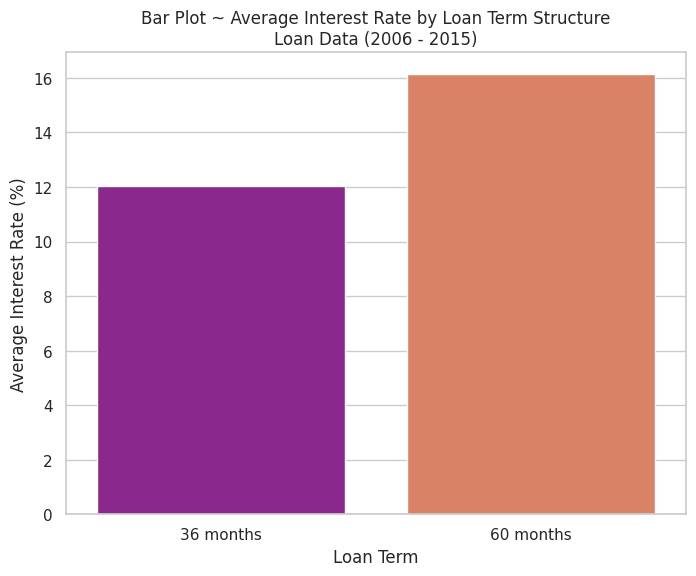

term   int_rate
0  36 months  12.028695
1  60 months  16.134810

In [56]:
avg_int_rates_term = interest_rate_df_eda.groupby('term')['int_rate'].mean().reset_index()
plt.figure(figsize = (8,6))
sns.barplot(x = 'term',y = 'int_rate',data = avg_int_rates_term,palette = 'plasma')
plt.title('Bar Plot ~ Average Interest Rate by Loan Term Structure\nLoan Data (2006 - 2015)')
plt.xlabel('Loan Term')
plt.ylabel('Average Interest Rate (%)')
plt.show()

display(avg_int_rates_term)

# Average Interest Rate (60 Months): 16%
# Average Interest Rate (36 Months): 12%
# Percentage Difference: 4%
# Key Insight:
# The average interest rate is higher for long term (60 months) loans as compared to
# short term loans (36 months). This is a reflection of increased cost of borrowing by
# the Lending Platform (LC) for long-term loans, in mitagting the risk associated with
# default.

##### E2 : How do interest rates vary by the grade of the loan?

<ipython-input-57-fd06f0f3d986>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'grade',y = 'int_rate',data = avg_int_rates_grade,palette = 'plasma')


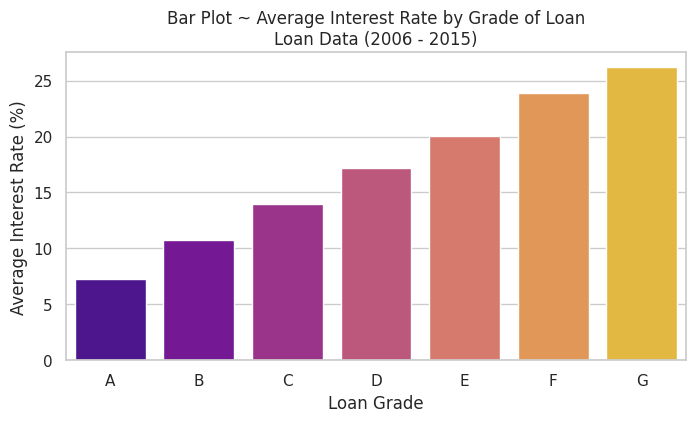

grade   int_rate
0     A   7.223463
1     B  10.772146
2     C  13.972226
3     D  17.220012
4     E  20.002694
5     F  23.875641
6     G  26.220042

In [57]:
avg_int_rates_grade = interest_rate_df_eda.groupby('grade')['int_rate'].mean().reset_index()
plt.figure(figsize = (8,4))
sns.barplot(x = 'grade',y = 'int_rate',data = avg_int_rates_grade,palette = 'plasma')
plt.title('Bar Plot ~ Average Interest Rate by Grade of Loan\nLoan Data (2006 - 2015)')
plt.xlabel('Loan Grade')
plt.ylabel('Average Interest Rate (%)')
plt.show()

display(avg_int_rates_grade)

# Highest Average Interest Rate (G): 26.22% (Approx.)
# Lowest Average Interest Rate (A): 7.22% (Approx.)
# Percentage Difference: 19% (Signficant Diff.)
# This is quiet expected as the loans that have greater risk have higher interest rates (Grade G), contrary to
# low risk loans which have lower interest rates.
# The risk of a loan depends on the borrowers characteristics, duration, prupose and borrowers credit profile.

##### E3 : How do interest rates vary by the sub-grade of the loan?

<ipython-input-58-457bc86255c5>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'sub_grade',y = 'int_rate',data = avg_int_rates_sub_grade,palette = 'plasma')


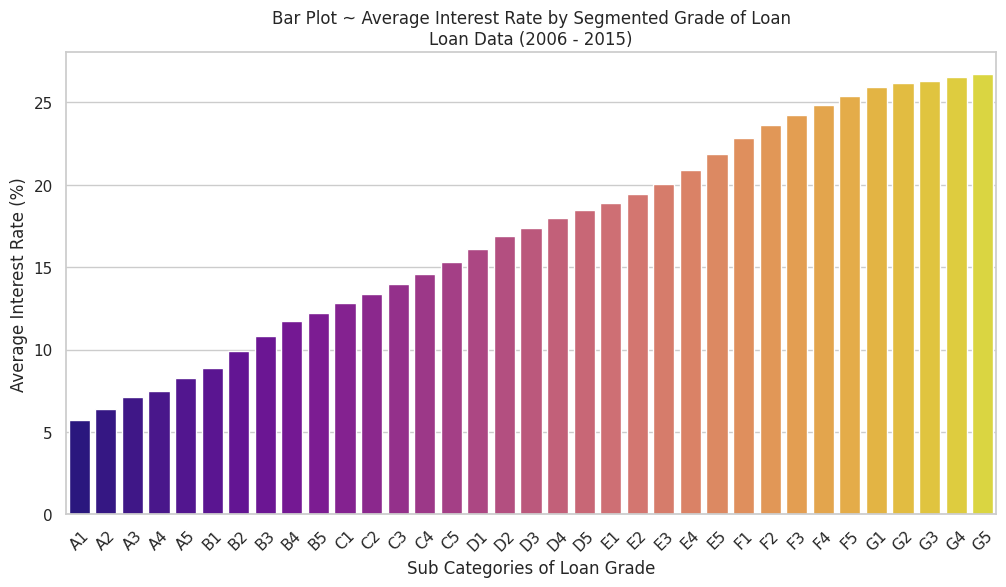

In [58]:
avg_int_rates_sub_grade = interest_rate_df_eda.groupby('sub_grade')['int_rate'].mean().reset_index()
plt.figure(figsize = (12,6))
sns.barplot(x = 'sub_grade',y = 'int_rate',data = avg_int_rates_sub_grade,palette = 'plasma')
plt.title('Bar Plot ~ Average Interest Rate by Segmented Grade of Loan\nLoan Data (2006 - 2015)')
plt.xlabel('Sub Categories of Loan Grade')
plt.ylabel('Average Interest Rate (%)')
plt.xticks(rotation = 45)
plt.show()

# display(avg_int_rates_sub_grade)

# Grade A Loans: (A1 - A5)
# Range : 5.69% - 8.25%
# Grade B Loans: (B1 - B5)
# Range : 8.87% - 12.25%
# Grade C Loans: (C1 - C5)
# Range : 12.85% - 15.32%
# Grade D Loans: (D1 - D5)
# Range : 16.09% - 18.49%
# Grade E Loans: (E1 - E5)
# Range : 18.91% - 21.86%
# Grade F Loans: (F1 - F5)
# Range : 22.84% - 25.38%
# Grade G Loans: (G1 - G5)
# Range : 25.94% - 26.71%

# There is a consistent growth in interest rates from loan grades A to G, which indicates higher risk loans
# are associated with higher average interest rates, the same holds true for the contrary. There is a noteable steep
# rise interest rates from D to G, which reflects decrease in borrowers credit risk profile and ability to pay-off debt
# payments.

##### E4 : Does the status of homeownership have an impact on interest rates?

<ipython-input-59-0a6a5923dba6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'home_ownership',y = 'int_rate',data = avg_int_rates_home_ownership,palette = 'plasma')


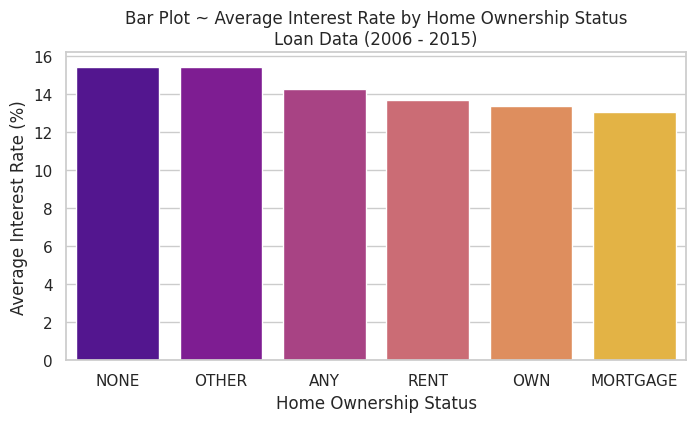

In [59]:
avg_int_rates_home_ownership = interest_rate_df_eda.groupby('home_ownership')['int_rate'].mean().reset_index().sort_values(by = 'int_rate',ascending = False)
plt.figure(figsize = (8,4))
sns.barplot(x = 'home_ownership',y = 'int_rate',data = avg_int_rates_home_ownership,palette = 'plasma')
plt.title('Bar Plot ~ Average Interest Rate by Home Ownership Status\nLoan Data (2006 - 2015)')
plt.xlabel('Home Ownership Status')
plt.ylabel('Average Interest Rate (%)')
plt.show()

# display(avg_int_rates_home_ownership)

# home_ownership	int_rate
# 1	MORTGAGE	13.035938
# 4	OWN	13.357274
# 5	RENT	13.651702
# 0	ANY	14.233333
# 3	OTHER	15.387073
# 2	NONE	15.412439

##### E5 : Does borrower verification have an impact on interest rates?

<ipython-input-60-a38d988c7f8c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'verification_status',y = 'int_rate',data = avg_int_rates_verification_status,palette = 'plasma')


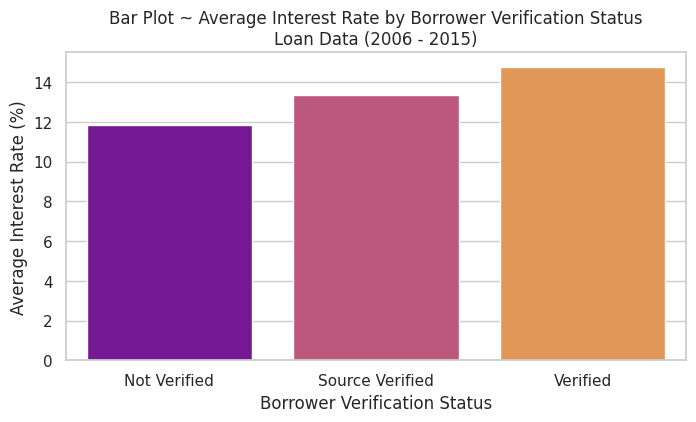

verification_status   int_rate
0        Not Verified  11.828076
1     Source Verified  13.354976
2            Verified  14.763968

In [60]:
avg_int_rates_verification_status = interest_rate_df_eda.groupby('verification_status')['int_rate'].mean().reset_index()
plt.figure(figsize = (8,4))
sns.barplot(x = 'verification_status',y = 'int_rate',data = avg_int_rates_verification_status,palette = 'plasma')
plt.title('Bar Plot ~ Average Interest Rate by Borrower Verification Status\nLoan Data (2006 - 2015)')
plt.xlabel('Borrower Verification Status')
plt.ylabel('Average Interest Rate (%)')
plt.show()

display(avg_int_rates_verification_status)

# verification_status	int_rate
# 0	Not Verified	11.828076
# 1	Source Verified	13.354976
# 2	Verified	14.763968

##### E6 : How do borrower interest rates vary with the state of the loan?

<ipython-input-61-99fa456d8143>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'loan_status',y = 'int_rate',data = avg_int_rates_loan_status,palette = 'plasma')


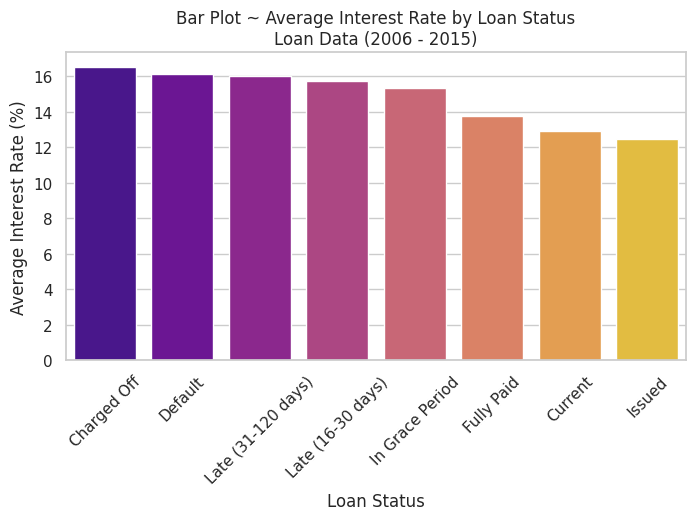

In [61]:
avg_int_rates_loan_status = interest_rate_df_eda.groupby('loan_status')['int_rate'].mean().reset_index().sort_values(by = 'int_rate',ascending = False)
plt.figure(figsize = (8,4))
sns.barplot(x = 'loan_status',y = 'int_rate',data = avg_int_rates_loan_status,palette = 'plasma')
plt.title('Bar Plot ~ Average Interest Rate by Loan Status\nLoan Data (2006 - 2015)')
plt.xlabel('Loan Status')
plt.xticks(rotation = 45)
plt.ylabel('Average Interest Rate (%)')
plt.show()

# display(avg_int_rates_loan_status)

# loan_status	int_rate
# 0	Charged Off	16.523485
# 2	Default	16.152115
# 7	Late (31-120 days)	16.031061
# 6	Late (16-30 days)	15.741731
# 4	In Grace Period	15.335485
# 3	Fully Paid	13.744272
# 1	Current	12.936926
# 5	Issued	12.452420

##### E7 : Does the geographical location impact the interest rate offered to the borrower?

<ipython-input-62-0abc7ab553fa>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'addr_state',y = 'int_rate',data = top_10_states,palette = 'plasma')


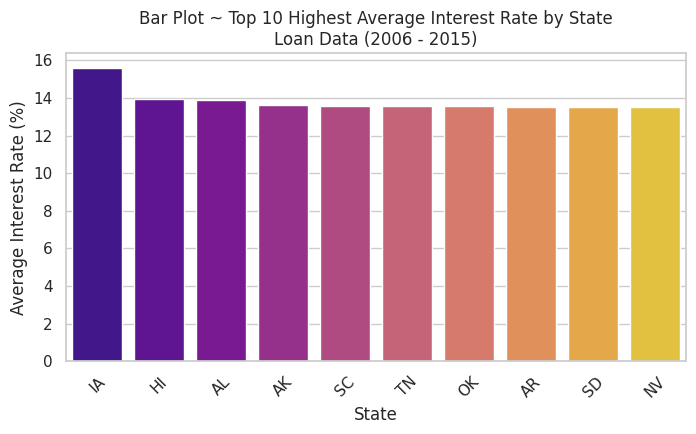

addr_state   int_rate
12         IA  15.610000
11         HI  13.967155
1          AL  13.870541
0          AK  13.609125
40         SC  13.587290
42         TN  13.586569
36         OK  13.556099
2          AR  13.533439
41         SD  13.525852
33         NV  13.522668

In [62]:
avg_int_rates_addr_state = interest_rate_df_eda.groupby('addr_state')['int_rate'].mean().reset_index().sort_values(by = 'int_rate',ascending = False)
top_10_states = avg_int_rates_addr_state.head(10)

plt.figure(figsize = (8,4))
sns.barplot(x = 'addr_state',y = 'int_rate',data = top_10_states,palette = 'plasma')
plt.title('Bar Plot ~ Top 10 Highest Average Interest Rate by State\nLoan Data (2006 - 2015)')
plt.xlabel('State')
plt.xticks(rotation = 45)
plt.ylabel('Average Interest Rate (%)')
plt.show()

display(top_10_states)

# addr_state	int_rate
# 12	IA	15.610000
# 11	HI	13.967155
# 1	AL	13.870541
# 0	AK	13.609125
# 40	SC	13.587290
# 42	TN	13.586569
# 36	OK	13.556099
# 2	AR	13.533439
# 41	SD	13.525852
# 33	NV	13.522668

##### E8 : How different are borrower interest rates for fractional and complete loans?

<ipython-input-63-61592031848c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'initial_list_status',y = 'int_rate',data = avg_int_rates_listing_status,palette = 'plasma')


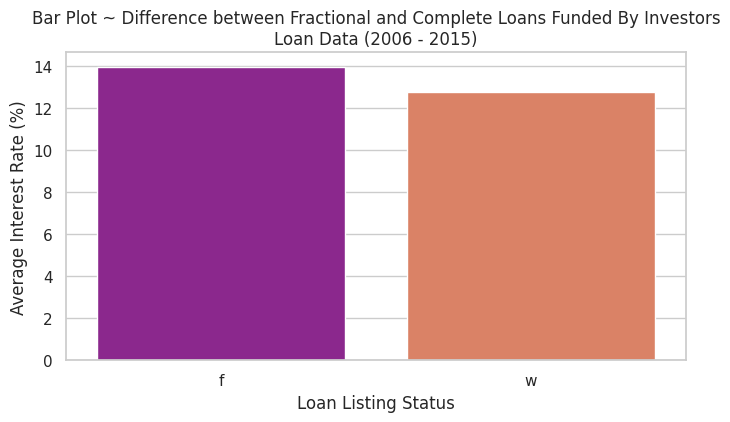

initial_list_status   int_rate
0                   f  13.949145
1                   w  12.746795

In [63]:
avg_int_rates_listing_status = interest_rate_df_eda.groupby('initial_list_status')['int_rate'].mean().reset_index()

plt.figure(figsize = (8,4))
sns.barplot(x = 'initial_list_status',y = 'int_rate',data = avg_int_rates_listing_status,palette = 'plasma')
plt.title('Bar Plot ~ Difference between Fractional and Complete Loans Funded By Investors\nLoan Data (2006 - 2015)')
plt.xlabel('Loan Listing Status')
plt.ylabel('Average Interest Rate (%)')
plt.show()

display(avg_int_rates_listing_status)

# initial_list_status	int_rate
# 0	f	13.949145
# 1	w	12.746795

##### 2.1 Payment Plan (Two-Sample T-Test)

In [64]:
# Since the homogeneity of variances has not been violated for the pymnt_plan variable
# we can proceede with Two-Sample T-Test for inspecting whether taking a payment plan
# signficantly affects interest rates. Since the payment variable has only 2 groups the
# suitable test for analysing the signifcance is a Two-Sample T-Test.

# Payment Plan : Apply Two-Sample T-Test
group_no = interest_rate_df_eda[interest_rate_df_eda['pymnt_plan'] == 'n']['int_rate']
group_yes = interest_rate_df_eda[interest_rate_df_eda['pymnt_plan'] == 'y']['int_rate']

# Determine the Test Statistic and p-value for Signficance
t_stat,p_value = stats.ttest_ind(group_no,group_yes)
print(f"Two-Sample T-Test -> Statistic: {t_stat:.5f},p-value: {p_value:.5f}")
# At the 5% level of signficance there is a signficant difference in interest rates
# between borrowers with and without a payment plan.

Two-Sample T-Test -> Statistic: -2.82040,p-value: 0.00480


##### 2.2 Evaluating Associations and Co-dependence between Categorical Variables

In [65]:
print(categorical_variables_eda)
print(len(categorical_variables_eda)) # 9

['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status', 'pymnt_plan', 'addr_state', 'initial_list_status']
9


In [66]:
signficant_categorical_vars_2 = ['term','grade','sub_grade','home_ownership','verification_status','loan_status','pymnt_plan','addr_state',
                                 'initial_list_status','purpose']
print(len(signficant_categorical_vars_2))

10


In [67]:
# Define Cramer's V Statistic for categorical variables
def cramers_v(x,y):
    table = pd.crosstab(x,y)
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    phi2 = chi2 / n
    r,k = table.shape
    phi2_corr = max(0,phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1),(r_corr-1)))

# Define a list that consists of all pairs of combinations
categorical_vars_pairs = list(itertools.combinations(interest_rate_df_eda[signficant_categorical_vars_2],2))

# Define an empty list for storing the results
results = []
for var1,var2 in categorical_vars_pairs:
    cramer_v_value = cramers_v(interest_rate_df_eda[var1],interest_rate_df_eda[var2])
    table = pd.crosstab(interest_rate_df_eda[var1],interest_rate_df_eda[var2])
    chi2,p,_,_ = chi2_contingency(table)
    results.append({
        'var1': var1,
        'var2': var2,
        'chi2_statistic': chi2,
        'p_value': p,
        'cramers_v': cramer_v_value,
        'dependent': 'Yes' if p < 0.05 else 'No'
    })

# Display the results in a data frame
categorical_associations_df = pd.DataFrame(results)
# display(categorical_associations_df)

# Function for classifying the strength of association between the pairs of categorical variables
# with cramers_statistic as the parameter
def association_strength(cramers_statistic):
    if cramers_statistic <= 0.1: # A cramers_v value of less than or equal to 0.1 is relative to a low association between the
                                 # categorical variables.
        return 'Low Association'
    elif cramers_statistic <= 0.3: # A cramers_v value of less than or equal to 0.3 is relative to a moderate association between the
                                   # categorical variables.
        return 'Moderate Association'
    else:
        return 'High Association' # A cramers_v value of greater than 0.3 is relative to a high association.

# Define a new variable to the data frame for association strength
categorical_associations_df['association_strength'] = categorical_associations_df['cramers_v'].apply(association_strength)
display(categorical_associations_df)

# Filter the data frame for high associations
categorical_high_assocations_df = categorical_associations_df[(categorical_associations_df['p_value'] < 0.05) & (categorical_associations_df['cramers_v'] > 0.3)]
display(categorical_high_assocations_df)

var1                 var2  chi2_statistic        p_value  \
0                  term                grade    1.542935e+05   0.000000e+00   
1                  term            sub_grade    1.638390e+05   0.000000e+00   
2                  term       home_ownership    9.273874e+03   0.000000e+00   
3                  term  verification_status    3.163797e+04   0.000000e+00   
4                  term          loan_status    9.343524e+03   0.000000e+00   
5                  term           pymnt_plan    0.000000e+00   1.000000e+00   
6                  term           addr_state    3.065832e+03   0.000000e+00   
7                  term  initial_list_status    1.265502e+04   0.000000e+00   
8                  term              purpose    6.897837e+03   0.000000e+00   
9                 grade            sub_grade    4.544964e+06   0.000000e+00   
10                grade       home_ownership    4.577776e+03   0.000000e+00   
11                grade  verification_status    4.541926e+04   0.000000e+00   
12                grade          loan_status    1.848349e+04   0.000000e+00   
13                grade           pymnt_plan    9.023804e+00   1.722438e-01   
14                grade           addr_state    1.928322e+03  2.515065e-235   
15                grade  initial_list_status    9.776373e+03   0.000000e+00   
16                grade              purpose    4.920379e+04   0.000000e+00   
17            sub_grade       home_ownership    5.826002e+03   0.000000e+00   
18            sub_grade  verification_status    5.221395e+04   0.000000e+00   
19            sub_grade          loan_status    2.024317e+04   0.000000e+00   
20            sub_grade           pymnt_plan    5.639937e+01   9.240102e-03   
21            sub_grade           addr_state    3.598980e+03  3.980167e-138   
22            sub_grade  initial_list_status    1.012194e+04   0.000000e+00   
23            sub_grade              purpose    5.353492e+04   0.000000e+00   
24       home_ownership  verification_status    1.588115e+03   0.000000e+00   
25       home_ownership          loan_status    1.579638e+03  7.441800e-310   
26       home_ownership           pymnt_plan    6.138611e+00   2.929642e-01   
27       home_ownership           addr_state    5.377091e+04   0.000000e+00   
28       home_ownership  initial_list_status    5.389471e+02  3.116531e-114   
29       home_ownership              purpose    2.468421e+04   0.000000e+00   
30  verification_status          loan_status    9.206838e+03   0.000000e+00   
31  verification_status           pymnt_plan    3.767046e+00   1.520535e-01   
32  verification_status           addr_state    1.089152e+03  6.565467e-166   
33  verification_status  initial_list_status    4.735906e+03   0.000000e+00   
34  verification_status              purpose    5.935416e+03   0.000000e+00   
35          loan_status           pymnt_plan    1.029404e+02   2.662402e-19   
36          loan_status           addr_state    3.981569e+03   0.000000e+00   
37          loan_status  initial_list_status    2.569416e+04   0.000000e+00   
38          loan_status              purpose    3.511234e+03   0.000000e+00   
39           pymnt_plan           addr_state    8.476745e+01   1.552552e-03   
40           pymnt_plan  initial_list_status    7.256830e-02   7.876334e-01   
41           pymnt_plan              purpose    1.861516e+01   1.355274e-01   
42           addr_state  initial_list_status    6.638566e+02  3.892308e-108   
43           addr_state              purpose    5.489133e+03   0.000000e+00   
44  initial_list_status              purpose    2.054647e+03   0.000000e+00   

    cramers_v dependent  association_strength  
0    0.451311       Yes      High Association  
1    0.465023       Yes      High Association  
2    0.110618       Yes  Moderate Association  
3    0.204363       Yes  Moderate Association  
4    0.111021       Yes  Moderate Association  
5    0.000000        No       Low Association  
6    0.063098       Yes       Low Association  


var1       var2  chi2_statistic  p_value  cramers_v dependent  \
0   term      grade    1.542935e+05      0.0   0.451311       Yes   
1   term  sub_grade    1.638390e+05      0.0   0.465023       Yes   
9  grade  sub_grade    4.544964e+06      0.0   0.999982       Yes   

  association_strength  
0     High Association  
1     High Association  
9     High Association

##### 2.3 How signficant is the 'Purpose' of the loan in the Prediction of Loan Interest Rates?

In [68]:
# Levene's Test for Homogeneity of Variances
int_rate_purpose_sig_test = [interest_rate_df_eda[interest_rate_df_eda['purpose'] == purpose]['int_rate'] for purpose in interest_rate_df_eda['purpose'].unique()]
stat,p_value = levene(*int_rate_purpose_sig_test)
print(f"Levene's Test Statistic: {stat}")
print(f"P-value: {p_value}") # The interest rate variances between the groups defined in 'purpose' is not equal and violates the assumption of homogeneity of
                             # variances.

# Kruskal-Wallis Test
stat,p_value = kruskal(*int_rate_purpose_sig_test)
print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p_value}") # Atleast one loan purpose has a sigfnificant difference in interest rate distribution.

# Dunns Test (Post-Hoc Analysis)
dunns_test_purpose = sp.posthoc_dunn(interest_rate_df_eda,val_col = 'int_rate',group_col = 'purpose',p_adjust = 'bonferroni')
# display(dunns_test_purpose)

int_rate_purpose_interpretation = dunn_test_interpretation(dunns_test_purpose,'purpose')
display(int_rate_purpose_interpretation) # All the groups are statistically significant. The loan purpose is a signficant factor in the
                                         # prediction of interest rates.

Levene's Test Statistic: 185.62041287921895
P-value: 0.0
Kruskal-Wallis Test Statistic: 44664.14790126302
P-value: 0.0
Significant differences found in purpose between the following groups:
  - car vs credit_card (p = 0.00000)
  - car vs debt_consolidation (p = 0.00000)
  - car vs home_improvement (p = 0.00000)
  - car vs house (p = 0.00000)
  - car vs major_purchase (p = 0.00000)
  - car vs medical (p = 0.00000)
  - car vs moving (p = 0.00000)
  - car vs other (p = 0.00000)
  - car vs renewable_energy (p = 0.00000)
  - car vs small_business (p = 0.00000)
  - car vs vacation (p = 0.00000)
  - car vs wedding (p = 0.00000)
  - credit_card vs car (p = 0.00000)
  - credit_card vs debt_consolidation (p = 0.00000)
  - credit_card vs home_improvement (p = 0.00000)
  - credit_card vs house (p = 0.00000)
  - credit_card vs major_purchase (p = 0.00000)
  - credit_card vs medical (p = 0.00000)
  - credit_card vs moving (p = 0.00000)
  - credit_card vs other (p = 0.00000)
  - credit_card vs renewa

None

<ipython-input-69-f7d9fc33eadb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'purpose',y = 'int_rate',data = avg_int_rates_purpose,palette = 'viridis')


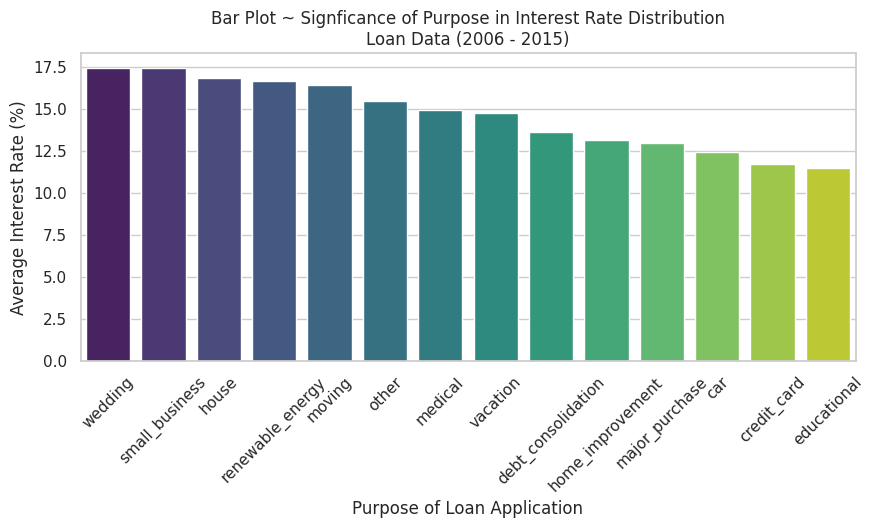

purpose   int_rate
13             wedding  17.478403
11      small_business  17.452527
5                house  16.849260
10    renewable_energy  16.661307
8               moving  16.472924
9                other  15.511849
7              medical  14.949525
12            vacation  14.791771
2   debt_consolidation  13.649247
4     home_improvement  13.161932
6       major_purchase  13.018326
0                  car  12.435570
1          credit_card  11.751027
3          educational  11.530000

In [69]:
# Signficance of Purpose in Interest Rate Distribution
avg_int_rates_purpose = interest_rate_df_eda.groupby('purpose')['int_rate'].mean().reset_index().sort_values(by = 'int_rate',ascending = False)
plt.figure(figsize = (10,4))
sns.barplot(x = 'purpose',y = 'int_rate',data = avg_int_rates_purpose,palette = 'viridis')
plt.title('Bar Plot ~ Signficance of Purpose in Interest Rate Distribution\nLoan Data (2006 - 2015)')
plt.xlabel('Purpose of Loan Application')
plt.xticks(rotation = 45)
plt.ylabel('Average Interest Rate (%)')
plt.show()

display(avg_int_rates_purpose)

# purpose	int_rate
# 3	educational	11.530000
# 1	credit_card	11.751027
# 0	car	12.435570
# 6	major_purchase	13.018326
# 4	home_improvement	13.161932
# 2	debt_consolidation	13.649247
# 12	vacation	14.791771
# 7	medical	14.949525
# 9	other	15.511849
# 8	moving	16.472924
# 10	renewable_energy	16.661307
# 5	house	16.849260
# 11	small_business	17.452527
# 13	wedding	17.478403